In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(871548, 1040)
(871548, 3)
validation
(152302, 1040)
(152302, 3)
test
(111835, 1040)
(111835, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/88 [..............................] - ETA: 2:43 - loss: 1.2447 - STD: 0.2552 - MAE: 0.4141

 3/88 [>.............................] - ETA: 2s - loss: 1.1479 - STD: 0.1387 - MAE: 0.4300  

 5/88 [>.............................] - ETA: 2s - loss: 1.1412 - STD: 0.1318 - MAE: 0.4333

 7/88 [=>............................] - ETA: 2s - loss: 1.1213 - STD: 0.1167 - MAE: 0.4331

 9/88 [==>...........................] - ETA: 2s - loss: 1.1114 - STD: 0.1174 - MAE: 0.4314

11/88 [==>...........................] - ETA: 2s - loss: 1.1069 - STD: 0.1205 - MAE: 0.4302

13/88 [===>..........................] - ETA: 2s - loss: 1.1008 - STD: 0.1172 - MAE: 0.4298

15/88 [====>.........................] - ETA: 2s - loss: 1.0943 - STD: 0.1111 - MAE: 0.4297

17/88 [====>.........................] - ETA: 2s - loss: 1.0894 - STD: 0.1077 - MAE: 0.4295

19/88 [=====>........................] - ETA: 2s - loss: 1.0848 - STD: 0.1053 - MAE: 0.4291

21/88 [======>.......................] - ETA: 1s - loss: 1.0787 - STD: 0.1026 - MAE: 0.4283

23/88 [======>.......................] - ETA: 1s - loss: 1.0718 - STD: 0.1014 - MAE: 0.4269

25/88 [=======>......................] - ETA: 1s - loss: 1.0638 - STD: 0.1017 - MAE: 0.4250

27/88 [========>.....................] - ETA: 1s - loss: 1.0533 - STD: 0.1021 - MAE: 0.4225

29/88 [========>.....................] - ETA: 1s - loss: 1.0401 - STD: 0.1036 - MAE: 0.4191

31/88 [=========>....................] - ETA: 1s - loss: 1.0239 - STD: 0.1078 - MAE: 0.4142

33/88 [==========>...................] - ETA: 1s - loss: 1.0063 - STD: 0.1141 - MAE: 0.4084

35/88 [==========>...................] - ETA: 1s - loss: 0.9872 - STD: 0.1209 - MAE: 0.4020

37/88 [===========>..................] - ETA: 1s - loss: 0.9683 - STD: 0.1287 - MAE: 0.3952

39/88 [============>.................] - ETA: 1s - loss: 0.9504 - STD: 0.1370 - MAE: 0.3882

41/88 [============>.................] - ETA: 1s - loss: 0.9332 - STD: 0.1451 - MAE: 0.3814

43/88 [=============>................] - ETA: 1s - loss: 0.9174 - STD: 0.1531 - MAE: 0.3748

45/88 [==============>...............] - ETA: 1s - loss: 0.9021 - STD: 0.1604 - MAE: 0.3685

47/88 [===============>..............] - ETA: 1s - loss: 0.8873 - STD: 0.1675 - MAE: 0.3623

49/88 [===============>..............] - ETA: 1s - loss: 0.8728 - STD: 0.1741 - MAE: 0.3564

51/88 [================>.............] - ETA: 1s - loss: 0.8583 - STD: 0.1803 - MAE: 0.3506

53/88 [=================>............] - ETA: 1s - loss: 0.8443 - STD: 0.1862 - MAE: 0.3450

55/88 [=================>............] - ETA: 0s - loss: 0.8303 - STD: 0.1917 - MAE: 0.3395

57/88 [==================>...........] - ETA: 0s - loss: 0.8163 - STD: 0.1972 - MAE: 0.3339

59/88 [===================>..........] - ETA: 0s - loss: 0.8023 - STD: 0.2025 - MAE: 0.3283

61/88 [===================>..........] - ETA: 0s - loss: 0.7880 - STD: 0.2078 - MAE: 0.3227

63/88 [====================>.........] - ETA: 0s - loss: 0.7737 - STD: 0.2129 - MAE: 0.3170

65/88 [=====================>........] - ETA: 0s - loss: 0.7599 - STD: 0.2181 - MAE: 0.3114

67/88 [=====================>........] - ETA: 0s - loss: 0.7466 - STD: 0.2232 - MAE: 0.3058

68/88 [======================>.......] - ETA: 0s - loss: 0.7456 - STD: 0.2257 - MAE: 0.3032

70/88 [======================>.......] - ETA: 0s - loss: 0.7325 - STD: 0.2307 - MAE: 0.2977

72/88 [=======================>......] - ETA: 0s - loss: 0.7200 - STD: 0.2356 - MAE: 0.2925

74/88 [========================>.....] - ETA: 0s - loss: 0.7082 - STD: 0.2403 - MAE: 0.2875

76/88 [========================>.....] - ETA: 0s - loss: 0.6969 - STD: 0.2449 - MAE: 0.2826

78/88 [=========================>....] - ETA: 0s - loss: 0.6860 - STD: 0.2492 - MAE: 0.2780

80/88 [==========================>...] - ETA: 0s - loss: 0.6754 - STD: 0.2533 - MAE: 0.2735

82/88 [==========================>...] - ETA: 0s - loss: 0.6654 - STD: 0.2573 - MAE: 0.2691

84/88 [===========================>..] - ETA: 0s - loss: 0.6561 - STD: 0.2611 - MAE: 0.2651

86/88 [============================>.] - ETA: 0s - loss: 0.6468 - STD: 0.2648 - MAE: 0.2611

88/88 [==============================] - ETA: 0s - loss: 0.6380 - STD: 0.2683 - MAE: 0.2573

88/88 [==============================] - 6s 51ms/step - loss: 0.6380 - STD: 0.2683 - MAE: 0.2573 - val_loss: 0.3093 - val_STD: 0.4144 - val_MAE: 0.1064


Epoch 2/10000


 1/88 [..............................] - ETA: 6s - loss: 0.2625 - STD: 0.4171 - MAE: 0.0957

 3/88 [>.............................] - ETA: 2s - loss: 0.2586 - STD: 0.4170 - MAE: 0.0947

 5/88 [>.............................] - ETA: 2s - loss: 0.2592 - STD: 0.4167 - MAE: 0.0952

 7/88 [=>............................] - ETA: 2s - loss: 0.2572 - STD: 0.4170 - MAE: 0.0945

 9/88 [==>...........................] - ETA: 2s - loss: 0.2560 - STD: 0.4167 - MAE: 0.0946

11/88 [==>...........................] - ETA: 2s - loss: 0.2553 - STD: 0.4168 - MAE: 0.0944

13/88 [===>..........................] - ETA: 2s - loss: 0.2536 - STD: 0.4166 - MAE: 0.0942

15/88 [====>.........................] - ETA: 2s - loss: 0.2529 - STD: 0.4168 - MAE: 0.0940

17/88 [====>.........................] - ETA: 2s - loss: 0.2509 - STD: 0.4168 - MAE: 0.0936

19/88 [=====>........................] - ETA: 2s - loss: 0.2502 - STD: 0.4170 - MAE: 0.0933

21/88 [======>.......................] - ETA: 1s - loss: 0.2487 - STD: 0.4173 - MAE: 0.0929

23/88 [======>.......................] - ETA: 1s - loss: 0.2476 - STD: 0.4174 - MAE: 0.0926

25/88 [=======>......................] - ETA: 1s - loss: 0.2464 - STD: 0.4177 - MAE: 0.0922

27/88 [========>.....................] - ETA: 1s - loss: 0.2458 - STD: 0.4178 - MAE: 0.0919

29/88 [========>.....................] - ETA: 1s - loss: 0.2452 - STD: 0.4180 - MAE: 0.0917

31/88 [=========>....................] - ETA: 1s - loss: 0.2442 - STD: 0.4183 - MAE: 0.0912

33/88 [==========>...................] - ETA: 1s - loss: 0.2437 - STD: 0.4184 - MAE: 0.0911

35/88 [==========>...................] - ETA: 1s - loss: 0.2429 - STD: 0.4186 - MAE: 0.0907

37/88 [===========>..................] - ETA: 1s - loss: 0.2426 - STD: 0.4188 - MAE: 0.0906

39/88 [============>.................] - ETA: 1s - loss: 0.2414 - STD: 0.4189 - MAE: 0.0902

42/88 [=============>................] - ETA: 1s - loss: 0.2404 - STD: 0.4192 - MAE: 0.0897

44/88 [==============>...............] - ETA: 1s - loss: 0.2395 - STD: 0.4195 - MAE: 0.0894

46/88 [==============>...............] - ETA: 1s - loss: 0.2386 - STD: 0.4197 - MAE: 0.0890

48/88 [===============>..............] - ETA: 1s - loss: 0.2378 - STD: 0.4199 - MAE: 0.0887

50/88 [================>.............] - ETA: 1s - loss: 0.2369 - STD: 0.4202 - MAE: 0.0883

52/88 [================>.............] - ETA: 1s - loss: 0.2359 - STD: 0.4204 - MAE: 0.0880

54/88 [=================>............] - ETA: 0s - loss: 0.2358 - STD: 0.4205 - MAE: 0.0879

56/88 [==================>...........] - ETA: 0s - loss: 0.2349 - STD: 0.4207 - MAE: 0.0876

58/88 [==================>...........] - ETA: 0s - loss: 0.2343 - STD: 0.4208 - MAE: 0.0874

60/88 [===================>..........] - ETA: 0s - loss: 0.2336 - STD: 0.4210 - MAE: 0.0872

62/88 [====================>.........] - ETA: 0s - loss: 0.2326 - STD: 0.4211 - MAE: 0.0868

64/88 [====================>.........] - ETA: 0s - loss: 0.2317 - STD: 0.4213 - MAE: 0.0865

66/88 [=====================>........] - ETA: 0s - loss: 0.2309 - STD: 0.4214 - MAE: 0.0863

68/88 [======================>.......] - ETA: 0s - loss: 0.2301 - STD: 0.4216 - MAE: 0.0860

70/88 [======================>.......] - ETA: 0s - loss: 0.2294 - STD: 0.4218 - MAE: 0.0857

72/88 [=======================>......] - ETA: 0s - loss: 0.2287 - STD: 0.4220 - MAE: 0.0854

74/88 [========================>.....] - ETA: 0s - loss: 0.2277 - STD: 0.4222 - MAE: 0.0850

76/88 [========================>.....] - ETA: 0s - loss: 0.2272 - STD: 0.4224 - MAE: 0.0848

78/88 [=========================>....] - ETA: 0s - loss: 0.2264 - STD: 0.4226 - MAE: 0.0845

80/88 [==========================>...] - ETA: 0s - loss: 0.2255 - STD: 0.4228 - MAE: 0.0842

82/88 [==========================>...] - ETA: 0s - loss: 0.2249 - STD: 0.4229 - MAE: 0.0840

84/88 [===========================>..] - ETA: 0s - loss: 0.2243 - STD: 0.4230 - MAE: 0.0838

86/88 [============================>.] - ETA: 0s - loss: 0.2236 - STD: 0.4232 - MAE: 0.0835

88/88 [==============================] - ETA: 0s - loss: 0.2231 - STD: 0.4233 - MAE: 0.0833

88/88 [==============================] - 3s 34ms/step - loss: 0.2231 - STD: 0.4233 - MAE: 0.0833 - val_loss: 0.2030 - val_STD: 0.4320 - val_MAE: 0.0712


Epoch 3/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1976 - STD: 0.4301 - MAE: 0.0733

 3/88 [>.............................] - ETA: 2s - loss: 0.1992 - STD: 0.4303 - MAE: 0.0735

 5/88 [>.............................] - ETA: 2s - loss: 0.1953 - STD: 0.4304 - MAE: 0.0725

 7/88 [=>............................] - ETA: 2s - loss: 0.1994 - STD: 0.4307 - MAE: 0.0732

 9/88 [==>...........................] - ETA: 2s - loss: 0.1986 - STD: 0.4305 - MAE: 0.0732

11/88 [==>...........................] - ETA: 2s - loss: 0.1981 - STD: 0.4305 - MAE: 0.0731

13/88 [===>..........................] - ETA: 2s - loss: 0.1969 - STD: 0.4306 - MAE: 0.0727

15/88 [====>.........................] - ETA: 2s - loss: 0.1981 - STD: 0.4307 - MAE: 0.0729

17/88 [====>.........................] - ETA: 2s - loss: 0.1972 - STD: 0.4307 - MAE: 0.0727

19/88 [=====>........................] - ETA: 1s - loss: 0.1967 - STD: 0.4308 - MAE: 0.0725

21/88 [======>.......................] - ETA: 1s - loss: 0.1964 - STD: 0.4308 - MAE: 0.0725

23/88 [======>.......................] - ETA: 1s - loss: 0.1952 - STD: 0.4309 - MAE: 0.0722

25/88 [=======>......................] - ETA: 1s - loss: 0.1946 - STD: 0.4310 - MAE: 0.0720

27/88 [========>.....................] - ETA: 1s - loss: 0.1941 - STD: 0.4311 - MAE: 0.0718

29/88 [========>.....................] - ETA: 1s - loss: 0.1936 - STD: 0.4311 - MAE: 0.0716

31/88 [=========>....................] - ETA: 1s - loss: 0.1927 - STD: 0.4311 - MAE: 0.0715

33/88 [==========>...................] - ETA: 1s - loss: 0.1918 - STD: 0.4312 - MAE: 0.0712

35/88 [==========>...................] - ETA: 1s - loss: 0.1911 - STD: 0.4313 - MAE: 0.0710

37/88 [===========>..................] - ETA: 1s - loss: 0.1901 - STD: 0.4314 - MAE: 0.0707

39/88 [============>.................] - ETA: 1s - loss: 0.1895 - STD: 0.4316 - MAE: 0.0704

41/88 [============>.................] - ETA: 1s - loss: 0.1897 - STD: 0.4317 - MAE: 0.0704

43/88 [=============>................] - ETA: 1s - loss: 0.1892 - STD: 0.4318 - MAE: 0.0702

45/88 [==============>...............] - ETA: 1s - loss: 0.1892 - STD: 0.4319 - MAE: 0.0701

47/88 [===============>..............] - ETA: 1s - loss: 0.1889 - STD: 0.4321 - MAE: 0.0699

49/88 [===============>..............] - ETA: 1s - loss: 0.1894 - STD: 0.4322 - MAE: 0.0699

51/88 [================>.............] - ETA: 1s - loss: 0.1890 - STD: 0.4323 - MAE: 0.0698

54/88 [=================>............] - ETA: 0s - loss: 0.1887 - STD: 0.4324 - MAE: 0.0695

56/88 [==================>...........] - ETA: 0s - loss: 0.1885 - STD: 0.4326 - MAE: 0.0694

58/88 [==================>...........] - ETA: 0s - loss: 0.1882 - STD: 0.4326 - MAE: 0.0693

60/88 [===================>..........] - ETA: 0s - loss: 0.1881 - STD: 0.4327 - MAE: 0.0693

62/88 [====================>.........] - ETA: 0s - loss: 0.1878 - STD: 0.4328 - MAE: 0.0691

64/88 [====================>.........] - ETA: 0s - loss: 0.1875 - STD: 0.4328 - MAE: 0.0691

66/88 [=====================>........] - ETA: 0s - loss: 0.1871 - STD: 0.4328 - MAE: 0.0689

68/88 [======================>.......] - ETA: 0s - loss: 0.1866 - STD: 0.4329 - MAE: 0.0688

70/88 [======================>.......] - ETA: 0s - loss: 0.1863 - STD: 0.4330 - MAE: 0.0687

72/88 [=======================>......] - ETA: 0s - loss: 0.1862 - STD: 0.4330 - MAE: 0.0686

74/88 [========================>.....] - ETA: 0s - loss: 0.1861 - STD: 0.4331 - MAE: 0.0686

76/88 [========================>.....] - ETA: 0s - loss: 0.1859 - STD: 0.4331 - MAE: 0.0685

78/88 [=========================>....] - ETA: 0s - loss: 0.1858 - STD: 0.4332 - MAE: 0.0685

80/88 [==========================>...] - ETA: 0s - loss: 0.1853 - STD: 0.4332 - MAE: 0.0683

82/88 [==========================>...] - ETA: 0s - loss: 0.1849 - STD: 0.4333 - MAE: 0.0682

84/88 [===========================>..] - ETA: 0s - loss: 0.1847 - STD: 0.4333 - MAE: 0.0682

86/88 [============================>.] - ETA: 0s - loss: 0.1845 - STD: 0.4333 - MAE: 0.0681

88/88 [==============================] - ETA: 0s - loss: 0.1842 - STD: 0.4334 - MAE: 0.0680

88/88 [==============================] - 3s 34ms/step - loss: 0.1842 - STD: 0.4334 - MAE: 0.0680 - val_loss: 0.1972 - val_STD: 0.4382 - val_MAE: 0.0644


Epoch 4/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1671 - STD: 0.4378 - MAE: 0.0617

 3/88 [>.............................] - ETA: 2s - loss: 0.1721 - STD: 0.4365 - MAE: 0.0633

 5/88 [>.............................] - ETA: 2s - loss: 0.1717 - STD: 0.4362 - MAE: 0.0634

 7/88 [=>............................] - ETA: 2s - loss: 0.1706 - STD: 0.4360 - MAE: 0.0633

 9/88 [==>...........................] - ETA: 2s - loss: 0.1693 - STD: 0.4361 - MAE: 0.0630

11/88 [==>...........................] - ETA: 2s - loss: 0.1688 - STD: 0.4359 - MAE: 0.0630

13/88 [===>..........................] - ETA: 2s - loss: 0.1686 - STD: 0.4360 - MAE: 0.0629

15/88 [====>.........................] - ETA: 2s - loss: 0.1676 - STD: 0.4361 - MAE: 0.0627

17/88 [====>.........................] - ETA: 1s - loss: 0.1676 - STD: 0.4361 - MAE: 0.0626

19/88 [=====>........................] - ETA: 1s - loss: 0.1677 - STD: 0.4361 - MAE: 0.0626

21/88 [======>.......................] - ETA: 1s - loss: 0.1676 - STD: 0.4362 - MAE: 0.0626

23/88 [======>.......................] - ETA: 1s - loss: 0.1684 - STD: 0.4362 - MAE: 0.0627

25/88 [=======>......................] - ETA: 1s - loss: 0.1683 - STD: 0.4364 - MAE: 0.0626

27/88 [========>.....................] - ETA: 1s - loss: 0.1682 - STD: 0.4363 - MAE: 0.0626

29/88 [========>.....................] - ETA: 1s - loss: 0.1683 - STD: 0.4364 - MAE: 0.0626

31/88 [=========>....................] - ETA: 1s - loss: 0.1684 - STD: 0.4363 - MAE: 0.0627

33/88 [==========>...................] - ETA: 1s - loss: 0.1686 - STD: 0.4364 - MAE: 0.0626

35/88 [==========>...................] - ETA: 1s - loss: 0.1680 - STD: 0.4364 - MAE: 0.0625

37/88 [===========>..................] - ETA: 1s - loss: 0.1679 - STD: 0.4365 - MAE: 0.0624

39/88 [============>.................] - ETA: 1s - loss: 0.1675 - STD: 0.4365 - MAE: 0.0623

41/88 [============>.................] - ETA: 1s - loss: 0.1673 - STD: 0.4366 - MAE: 0.0622

43/88 [=============>................] - ETA: 1s - loss: 0.1669 - STD: 0.4366 - MAE: 0.0621

45/88 [==============>...............] - ETA: 1s - loss: 0.1664 - STD: 0.4367 - MAE: 0.0620

47/88 [===============>..............] - ETA: 1s - loss: 0.1659 - STD: 0.4368 - MAE: 0.0618

49/88 [===============>..............] - ETA: 1s - loss: 0.1659 - STD: 0.4368 - MAE: 0.0617

51/88 [================>.............] - ETA: 1s - loss: 0.1655 - STD: 0.4369 - MAE: 0.0616

53/88 [=================>............] - ETA: 0s - loss: 0.1654 - STD: 0.4370 - MAE: 0.0615

55/88 [=================>............] - ETA: 0s - loss: 0.1653 - STD: 0.4370 - MAE: 0.0615

57/88 [==================>...........] - ETA: 0s - loss: 0.1656 - STD: 0.4371 - MAE: 0.0615

59/88 [===================>..........] - ETA: 0s - loss: 0.1656 - STD: 0.4371 - MAE: 0.0615

61/88 [===================>..........] - ETA: 0s - loss: 0.1659 - STD: 0.4371 - MAE: 0.0615

64/88 [====================>.........] - ETA: 0s - loss: 0.1662 - STD: 0.4371 - MAE: 0.0616

66/88 [=====================>........] - ETA: 0s - loss: 0.1668 - STD: 0.4372 - MAE: 0.0617

68/88 [======================>.......] - ETA: 0s - loss: 0.1670 - STD: 0.4372 - MAE: 0.0617

70/88 [======================>.......] - ETA: 0s - loss: 0.1673 - STD: 0.4372 - MAE: 0.0617

72/88 [=======================>......] - ETA: 0s - loss: 0.1672 - STD: 0.4372 - MAE: 0.0617

74/88 [========================>.....] - ETA: 0s - loss: 0.1673 - STD: 0.4372 - MAE: 0.0617

76/88 [========================>.....] - ETA: 0s - loss: 0.1671 - STD: 0.4372 - MAE: 0.0617

78/88 [=========================>....] - ETA: 0s - loss: 0.1671 - STD: 0.4372 - MAE: 0.0617

80/88 [==========================>...] - ETA: 0s - loss: 0.1671 - STD: 0.4372 - MAE: 0.0617

82/88 [==========================>...] - ETA: 0s - loss: 0.1670 - STD: 0.4372 - MAE: 0.0617

84/88 [===========================>..] - ETA: 0s - loss: 0.1670 - STD: 0.4372 - MAE: 0.0617

86/88 [============================>.] - ETA: 0s - loss: 0.1670 - STD: 0.4372 - MAE: 0.0617

88/88 [==============================] - ETA: 0s - loss: 0.1671 - STD: 0.4372 - MAE: 0.0617

88/88 [==============================] - 3s 34ms/step - loss: 0.1671 - STD: 0.4372 - MAE: 0.0617 - val_loss: 0.1945 - val_STD: 0.4395 - val_MAE: 0.0630


Epoch 5/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1594 - STD: 0.4379 - MAE: 0.0599

 3/88 [>.............................] - ETA: 2s - loss: 0.1665 - STD: 0.4383 - MAE: 0.0609

 6/88 [=>............................] - ETA: 2s - loss: 0.1619 - STD: 0.4388 - MAE: 0.0587

 8/88 [=>............................] - ETA: 2s - loss: 0.1616 - STD: 0.4386 - MAE: 0.0590

10/88 [==>...........................] - ETA: 2s - loss: 0.1608 - STD: 0.4386 - MAE: 0.0590

12/88 [===>..........................] - ETA: 2s - loss: 0.1618 - STD: 0.4385 - MAE: 0.0593

14/88 [===>..........................] - ETA: 2s - loss: 0.1623 - STD: 0.4385 - MAE: 0.0595

16/88 [====>.........................] - ETA: 2s - loss: 0.1620 - STD: 0.4385 - MAE: 0.0595

18/88 [=====>........................] - ETA: 1s - loss: 0.1613 - STD: 0.4385 - MAE: 0.0594

20/88 [=====>........................] - ETA: 1s - loss: 0.1629 - STD: 0.4384 - MAE: 0.0598

22/88 [======>.......................] - ETA: 1s - loss: 0.1635 - STD: 0.4386 - MAE: 0.0598

24/88 [=======>......................] - ETA: 1s - loss: 0.1632 - STD: 0.4385 - MAE: 0.0598

26/88 [=======>......................] - ETA: 1s - loss: 0.1627 - STD: 0.4385 - MAE: 0.0597

28/88 [========>.....................] - ETA: 1s - loss: 0.1626 - STD: 0.4386 - MAE: 0.0597

30/88 [=========>....................] - ETA: 1s - loss: 0.1624 - STD: 0.4385 - MAE: 0.0597

32/88 [=========>....................] - ETA: 1s - loss: 0.1628 - STD: 0.4385 - MAE: 0.0598

34/88 [==========>...................] - ETA: 1s - loss: 0.1625 - STD: 0.4385 - MAE: 0.0598

36/88 [===========>..................] - ETA: 1s - loss: 0.1628 - STD: 0.4385 - MAE: 0.0599

38/88 [===========>..................] - ETA: 1s - loss: 0.1624 - STD: 0.4384 - MAE: 0.0598

40/88 [============>.................] - ETA: 1s - loss: 0.1622 - STD: 0.4384 - MAE: 0.0598

42/88 [=============>................] - ETA: 1s - loss: 0.1619 - STD: 0.4385 - MAE: 0.0597

44/88 [==============>...............] - ETA: 1s - loss: 0.1619 - STD: 0.4385 - MAE: 0.0597

46/88 [==============>...............] - ETA: 1s - loss: 0.1613 - STD: 0.4385 - MAE: 0.0595

48/88 [===============>..............] - ETA: 1s - loss: 0.1609 - STD: 0.4386 - MAE: 0.0594

50/88 [================>.............] - ETA: 1s - loss: 0.1607 - STD: 0.4386 - MAE: 0.0594

52/88 [================>.............] - ETA: 1s - loss: 0.1605 - STD: 0.4386 - MAE: 0.0593

54/88 [=================>............] - ETA: 0s - loss: 0.1604 - STD: 0.4387 - MAE: 0.0593

56/88 [==================>...........] - ETA: 0s - loss: 0.1601 - STD: 0.4386 - MAE: 0.0593

58/88 [==================>...........] - ETA: 0s - loss: 0.1598 - STD: 0.4387 - MAE: 0.0591

60/88 [===================>..........] - ETA: 0s - loss: 0.1597 - STD: 0.4387 - MAE: 0.0591

62/88 [====================>.........] - ETA: 0s - loss: 0.1599 - STD: 0.4387 - MAE: 0.0591

64/88 [====================>.........] - ETA: 0s - loss: 0.1597 - STD: 0.4388 - MAE: 0.0591

66/88 [=====================>........] - ETA: 0s - loss: 0.1596 - STD: 0.4388 - MAE: 0.0590

68/88 [======================>.......] - ETA: 0s - loss: 0.1595 - STD: 0.4388 - MAE: 0.0590

70/88 [======================>.......] - ETA: 0s - loss: 0.1595 - STD: 0.4388 - MAE: 0.0590

72/88 [=======================>......] - ETA: 0s - loss: 0.1594 - STD: 0.4389 - MAE: 0.0590

74/88 [========================>.....] - ETA: 0s - loss: 0.1594 - STD: 0.4389 - MAE: 0.0590

76/88 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.4389 - MAE: 0.0590

78/88 [=========================>....] - ETA: 0s - loss: 0.1595 - STD: 0.4389 - MAE: 0.0590

80/88 [==========================>...] - ETA: 0s - loss: 0.1594 - STD: 0.4389 - MAE: 0.0589

82/88 [==========================>...] - ETA: 0s - loss: 0.1592 - STD: 0.4389 - MAE: 0.0589

84/88 [===========================>..] - ETA: 0s - loss: 0.1592 - STD: 0.4389 - MAE: 0.0589

86/88 [============================>.] - ETA: 0s - loss: 0.1591 - STD: 0.4389 - MAE: 0.0589

88/88 [==============================] - ETA: 0s - loss: 0.1589 - STD: 0.4389 - MAE: 0.0589

88/88 [==============================] - 3s 34ms/step - loss: 0.1589 - STD: 0.4389 - MAE: 0.0589 - val_loss: 0.1907 - val_STD: 0.4413 - val_MAE: 0.0610


Epoch 6/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1567 - STD: 0.4390 - MAE: 0.0584

 3/88 [>.............................] - ETA: 2s - loss: 0.1573 - STD: 0.4393 - MAE: 0.0584

 5/88 [>.............................] - ETA: 2s - loss: 0.1568 - STD: 0.4395 - MAE: 0.0582

 7/88 [=>............................] - ETA: 2s - loss: 0.1550 - STD: 0.4399 - MAE: 0.0575

 9/88 [==>...........................] - ETA: 2s - loss: 0.1564 - STD: 0.4399 - MAE: 0.0579

11/88 [==>...........................] - ETA: 2s - loss: 0.1555 - STD: 0.4401 - MAE: 0.0574

13/88 [===>..........................] - ETA: 2s - loss: 0.1553 - STD: 0.4402 - MAE: 0.0573

15/88 [====>.........................] - ETA: 2s - loss: 0.1558 - STD: 0.4402 - MAE: 0.0574

17/88 [====>.........................] - ETA: 1s - loss: 0.1556 - STD: 0.4402 - MAE: 0.0573

19/88 [=====>........................] - ETA: 1s - loss: 0.1553 - STD: 0.4402 - MAE: 0.0572

21/88 [======>.......................] - ETA: 1s - loss: 0.1548 - STD: 0.4402 - MAE: 0.0571

23/88 [======>.......................] - ETA: 1s - loss: 0.1553 - STD: 0.4402 - MAE: 0.0572

25/88 [=======>......................] - ETA: 1s - loss: 0.1555 - STD: 0.4401 - MAE: 0.0573

27/88 [========>.....................] - ETA: 1s - loss: 0.1547 - STD: 0.4402 - MAE: 0.0571

29/88 [========>.....................] - ETA: 1s - loss: 0.1542 - STD: 0.4402 - MAE: 0.0570

31/88 [=========>....................] - ETA: 1s - loss: 0.1544 - STD: 0.4401 - MAE: 0.0571

33/88 [==========>...................] - ETA: 1s - loss: 0.1541 - STD: 0.4401 - MAE: 0.0571

35/88 [==========>...................] - ETA: 1s - loss: 0.1537 - STD: 0.4401 - MAE: 0.0570

37/88 [===========>..................] - ETA: 1s - loss: 0.1536 - STD: 0.4401 - MAE: 0.0569

39/88 [============>.................] - ETA: 1s - loss: 0.1534 - STD: 0.4401 - MAE: 0.0569

41/88 [============>.................] - ETA: 1s - loss: 0.1531 - STD: 0.4401 - MAE: 0.0569

43/88 [=============>................] - ETA: 1s - loss: 0.1533 - STD: 0.4401 - MAE: 0.0569

45/88 [==============>...............] - ETA: 1s - loss: 0.1531 - STD: 0.4401 - MAE: 0.0569

47/88 [===============>..............] - ETA: 1s - loss: 0.1526 - STD: 0.4401 - MAE: 0.0568

49/88 [===============>..............] - ETA: 1s - loss: 0.1526 - STD: 0.4401 - MAE: 0.0568

51/88 [================>.............] - ETA: 1s - loss: 0.1524 - STD: 0.4402 - MAE: 0.0567

53/88 [=================>............] - ETA: 0s - loss: 0.1524 - STD: 0.4402 - MAE: 0.0567

55/88 [=================>............] - ETA: 0s - loss: 0.1525 - STD: 0.4402 - MAE: 0.0567

57/88 [==================>...........] - ETA: 0s - loss: 0.1524 - STD: 0.4402 - MAE: 0.0567

59/88 [===================>..........] - ETA: 0s - loss: 0.1522 - STD: 0.4402 - MAE: 0.0566

61/88 [===================>..........] - ETA: 0s - loss: 0.1521 - STD: 0.4403 - MAE: 0.0565

63/88 [====================>.........] - ETA: 0s - loss: 0.1519 - STD: 0.4403 - MAE: 0.0564

65/88 [=====================>........] - ETA: 0s - loss: 0.1517 - STD: 0.4403 - MAE: 0.0564

67/88 [=====================>........] - ETA: 0s - loss: 0.1517 - STD: 0.4403 - MAE: 0.0564

69/88 [======================>.......] - ETA: 0s - loss: 0.1516 - STD: 0.4403 - MAE: 0.0564

71/88 [=======================>......] - ETA: 0s - loss: 0.1514 - STD: 0.4404 - MAE: 0.0563

73/88 [=======================>......] - ETA: 0s - loss: 0.1512 - STD: 0.4404 - MAE: 0.0563

76/88 [========================>.....] - ETA: 0s - loss: 0.1510 - STD: 0.4404 - MAE: 0.0562

78/88 [=========================>....] - ETA: 0s - loss: 0.1508 - STD: 0.4404 - MAE: 0.0562

80/88 [==========================>...] - ETA: 0s - loss: 0.1505 - STD: 0.4404 - MAE: 0.0561

82/88 [==========================>...] - ETA: 0s - loss: 0.1505 - STD: 0.4405 - MAE: 0.0561

84/88 [===========================>..] - ETA: 0s - loss: 0.1506 - STD: 0.4405 - MAE: 0.0561

86/88 [============================>.] - ETA: 0s - loss: 0.1506 - STD: 0.4405 - MAE: 0.0560

88/88 [==============================] - ETA: 0s - loss: 0.1507 - STD: 0.4405 - MAE: 0.0560

88/88 [==============================] - 3s 34ms/step - loss: 0.1507 - STD: 0.4405 - MAE: 0.0560 - val_loss: 0.1897 - val_STD: 0.4442 - val_MAE: 0.0581


Epoch 7/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1627 - STD: 0.4412 - MAE: 0.0578

 3/88 [>.............................] - ETA: 2s - loss: 0.1563 - STD: 0.4416 - MAE: 0.0562

 5/88 [>.............................] - ETA: 2s - loss: 0.1562 - STD: 0.4416 - MAE: 0.0562

 7/88 [=>............................] - ETA: 2s - loss: 0.1544 - STD: 0.4415 - MAE: 0.0560

 9/88 [==>...........................] - ETA: 2s - loss: 0.1531 - STD: 0.4413 - MAE: 0.0559

11/88 [==>...........................] - ETA: 2s - loss: 0.1517 - STD: 0.4413 - MAE: 0.0557

13/88 [===>..........................] - ETA: 2s - loss: 0.1506 - STD: 0.4411 - MAE: 0.0557

15/88 [====>.........................] - ETA: 2s - loss: 0.1497 - STD: 0.4412 - MAE: 0.0554

17/88 [====>.........................] - ETA: 1s - loss: 0.1496 - STD: 0.4412 - MAE: 0.0554

19/88 [=====>........................] - ETA: 1s - loss: 0.1497 - STD: 0.4411 - MAE: 0.0555

21/88 [======>.......................] - ETA: 1s - loss: 0.1501 - STD: 0.4411 - MAE: 0.0556

23/88 [======>.......................] - ETA: 1s - loss: 0.1501 - STD: 0.4410 - MAE: 0.0556

25/88 [=======>......................] - ETA: 1s - loss: 0.1493 - STD: 0.4410 - MAE: 0.0554

27/88 [========>.....................] - ETA: 1s - loss: 0.1491 - STD: 0.4411 - MAE: 0.0553

29/88 [========>.....................] - ETA: 1s - loss: 0.1487 - STD: 0.4411 - MAE: 0.0553

31/88 [=========>....................] - ETA: 1s - loss: 0.1485 - STD: 0.4411 - MAE: 0.0553

33/88 [==========>...................] - ETA: 1s - loss: 0.1487 - STD: 0.4411 - MAE: 0.0553

35/88 [==========>...................] - ETA: 1s - loss: 0.1484 - STD: 0.4411 - MAE: 0.0552

37/88 [===========>..................] - ETA: 1s - loss: 0.1484 - STD: 0.4411 - MAE: 0.0552

39/88 [============>.................] - ETA: 1s - loss: 0.1485 - STD: 0.4412 - MAE: 0.0551

41/88 [============>.................] - ETA: 1s - loss: 0.1485 - STD: 0.4412 - MAE: 0.0551

43/88 [=============>................] - ETA: 1s - loss: 0.1489 - STD: 0.4412 - MAE: 0.0552

45/88 [==============>...............] - ETA: 1s - loss: 0.1488 - STD: 0.4412 - MAE: 0.0552

47/88 [===============>..............] - ETA: 1s - loss: 0.1486 - STD: 0.4412 - MAE: 0.0551

49/88 [===============>..............] - ETA: 1s - loss: 0.1481 - STD: 0.4412 - MAE: 0.0550

51/88 [================>.............] - ETA: 1s - loss: 0.1481 - STD: 0.4412 - MAE: 0.0550

53/88 [=================>............] - ETA: 1s - loss: 0.1480 - STD: 0.4412 - MAE: 0.0550

55/88 [=================>............] - ETA: 0s - loss: 0.1478 - STD: 0.4413 - MAE: 0.0549

57/88 [==================>...........] - ETA: 0s - loss: 0.1478 - STD: 0.4412 - MAE: 0.0550

59/88 [===================>..........] - ETA: 0s - loss: 0.1479 - STD: 0.4413 - MAE: 0.0550

61/88 [===================>..........] - ETA: 0s - loss: 0.1481 - STD: 0.4413 - MAE: 0.0550

63/88 [====================>.........] - ETA: 0s - loss: 0.1480 - STD: 0.4413 - MAE: 0.0549

65/88 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.4413 - MAE: 0.0549

67/88 [=====================>........] - ETA: 0s - loss: 0.1477 - STD: 0.4414 - MAE: 0.0548

69/88 [======================>.......] - ETA: 0s - loss: 0.1475 - STD: 0.4414 - MAE: 0.0548

71/88 [=======================>......] - ETA: 0s - loss: 0.1474 - STD: 0.4414 - MAE: 0.0547

73/88 [=======================>......] - ETA: 0s - loss: 0.1473 - STD: 0.4415 - MAE: 0.0547

75/88 [========================>.....] - ETA: 0s - loss: 0.1471 - STD: 0.4415 - MAE: 0.0547

77/88 [=========================>....] - ETA: 0s - loss: 0.1469 - STD: 0.4415 - MAE: 0.0546

79/88 [=========================>....] - ETA: 0s - loss: 0.1470 - STD: 0.4415 - MAE: 0.0546

81/88 [==========================>...] - ETA: 0s - loss: 0.1470 - STD: 0.4415 - MAE: 0.0546

83/88 [===========================>..] - ETA: 0s - loss: 0.1470 - STD: 0.4415 - MAE: 0.0546

86/88 [============================>.] - ETA: 0s - loss: 0.1470 - STD: 0.4415 - MAE: 0.0546

88/88 [==============================] - ETA: 0s - loss: 0.1467 - STD: 0.4416 - MAE: 0.0545

88/88 [==============================] - 3s 33ms/step - loss: 0.1467 - STD: 0.4416 - MAE: 0.0545 - val_loss: 0.2053 - val_STD: 0.4428 - val_MAE: 0.0618


Epoch 8/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1387 - STD: 0.4417 - MAE: 0.0531

 3/88 [>.............................] - ETA: 2s - loss: 0.1445 - STD: 0.4421 - MAE: 0.0537

 5/88 [>.............................] - ETA: 2s - loss: 0.1411 - STD: 0.4423 - MAE: 0.0529

 7/88 [=>............................] - ETA: 2s - loss: 0.1417 - STD: 0.4418 - MAE: 0.0533

 9/88 [==>...........................] - ETA: 2s - loss: 0.1423 - STD: 0.4418 - MAE: 0.0534

11/88 [==>...........................] - ETA: 2s - loss: 0.1436 - STD: 0.4417 - MAE: 0.0538

13/88 [===>..........................] - ETA: 2s - loss: 0.1439 - STD: 0.4418 - MAE: 0.0539

15/88 [====>.........................] - ETA: 2s - loss: 0.1444 - STD: 0.4420 - MAE: 0.0538

17/88 [====>.........................] - ETA: 2s - loss: 0.1440 - STD: 0.4420 - MAE: 0.0537

19/88 [=====>........................] - ETA: 2s - loss: 0.1441 - STD: 0.4420 - MAE: 0.0537

21/88 [======>.......................] - ETA: 2s - loss: 0.1437 - STD: 0.4421 - MAE: 0.0536

23/88 [======>.......................] - ETA: 1s - loss: 0.1440 - STD: 0.4420 - MAE: 0.0537

25/88 [=======>......................] - ETA: 1s - loss: 0.1445 - STD: 0.4420 - MAE: 0.0538

27/88 [========>.....................] - ETA: 1s - loss: 0.1442 - STD: 0.4420 - MAE: 0.0537

30/88 [=========>....................] - ETA: 1s - loss: 0.1457 - STD: 0.4419 - MAE: 0.0542

32/88 [=========>....................] - ETA: 1s - loss: 0.1462 - STD: 0.4419 - MAE: 0.0544

34/88 [==========>...................] - ETA: 1s - loss: 0.1478 - STD: 0.4419 - MAE: 0.0547

36/88 [===========>..................] - ETA: 1s - loss: 0.1485 - STD: 0.4418 - MAE: 0.0548

38/88 [===========>..................] - ETA: 1s - loss: 0.1487 - STD: 0.4417 - MAE: 0.0549

40/88 [============>.................] - ETA: 1s - loss: 0.1488 - STD: 0.4418 - MAE: 0.0549

42/88 [=============>................] - ETA: 1s - loss: 0.1487 - STD: 0.4418 - MAE: 0.0549

44/88 [==============>...............] - ETA: 1s - loss: 0.1485 - STD: 0.4419 - MAE: 0.0548

46/88 [==============>...............] - ETA: 1s - loss: 0.1479 - STD: 0.4419 - MAE: 0.0547

48/88 [===============>..............] - ETA: 1s - loss: 0.1479 - STD: 0.4419 - MAE: 0.0547

50/88 [================>.............] - ETA: 1s - loss: 0.1475 - STD: 0.4419 - MAE: 0.0545

52/88 [================>.............] - ETA: 1s - loss: 0.1472 - STD: 0.4419 - MAE: 0.0545

54/88 [=================>............] - ETA: 0s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0544

56/88 [==================>...........] - ETA: 0s - loss: 0.1466 - STD: 0.4419 - MAE: 0.0543

58/88 [==================>...........] - ETA: 0s - loss: 0.1464 - STD: 0.4419 - MAE: 0.0543

60/88 [===================>..........] - ETA: 0s - loss: 0.1461 - STD: 0.4419 - MAE: 0.0542

62/88 [====================>.........] - ETA: 0s - loss: 0.1461 - STD: 0.4419 - MAE: 0.0542

64/88 [====================>.........] - ETA: 0s - loss: 0.1460 - STD: 0.4419 - MAE: 0.0543

66/88 [=====================>........] - ETA: 0s - loss: 0.1458 - STD: 0.4419 - MAE: 0.0542

68/88 [======================>.......] - ETA: 0s - loss: 0.1453 - STD: 0.4418 - MAE: 0.0541

70/88 [======================>.......] - ETA: 0s - loss: 0.1451 - STD: 0.4418 - MAE: 0.0541

72/88 [=======================>......] - ETA: 0s - loss: 0.1448 - STD: 0.4419 - MAE: 0.0540

74/88 [========================>.....] - ETA: 0s - loss: 0.1447 - STD: 0.4419 - MAE: 0.0539

76/88 [========================>.....] - ETA: 0s - loss: 0.1446 - STD: 0.4419 - MAE: 0.0539

78/88 [=========================>....] - ETA: 0s - loss: 0.1445 - STD: 0.4419 - MAE: 0.0539

80/88 [==========================>...] - ETA: 0s - loss: 0.1445 - STD: 0.4420 - MAE: 0.0539

82/88 [==========================>...] - ETA: 0s - loss: 0.1445 - STD: 0.4420 - MAE: 0.0539

84/88 [===========================>..] - ETA: 0s - loss: 0.1445 - STD: 0.4420 - MAE: 0.0538

86/88 [============================>.] - ETA: 0s - loss: 0.1444 - STD: 0.4420 - MAE: 0.0538

88/88 [==============================] - ETA: 0s - loss: 0.1444 - STD: 0.4420 - MAE: 0.0538

88/88 [==============================] - 3s 34ms/step - loss: 0.1444 - STD: 0.4420 - MAE: 0.0538 - val_loss: 0.1943 - val_STD: 0.4449 - val_MAE: 0.0583


Epoch 9/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1493 - STD: 0.4426 - MAE: 0.0542

 3/88 [>.............................] - ETA: 2s - loss: 0.1459 - STD: 0.4427 - MAE: 0.0532

 5/88 [>.............................] - ETA: 2s - loss: 0.1468 - STD: 0.4428 - MAE: 0.0534

 7/88 [=>............................] - ETA: 2s - loss: 0.1433 - STD: 0.4430 - MAE: 0.0526

 9/88 [==>...........................] - ETA: 2s - loss: 0.1428 - STD: 0.4430 - MAE: 0.0526

11/88 [==>...........................] - ETA: 2s - loss: 0.1408 - STD: 0.4430 - MAE: 0.0521

13/88 [===>..........................] - ETA: 2s - loss: 0.1403 - STD: 0.4432 - MAE: 0.0519

15/88 [====>.........................] - ETA: 2s - loss: 0.1405 - STD: 0.4431 - MAE: 0.0520

17/88 [====>.........................] - ETA: 2s - loss: 0.1399 - STD: 0.4432 - MAE: 0.0517

19/88 [=====>........................] - ETA: 2s - loss: 0.1402 - STD: 0.4432 - MAE: 0.0518

21/88 [======>.......................] - ETA: 2s - loss: 0.1406 - STD: 0.4431 - MAE: 0.0520

23/88 [======>.......................] - ETA: 1s - loss: 0.1407 - STD: 0.4432 - MAE: 0.0520

25/88 [=======>......................] - ETA: 1s - loss: 0.1427 - STD: 0.4430 - MAE: 0.0525

27/88 [========>.....................] - ETA: 1s - loss: 0.1428 - STD: 0.4429 - MAE: 0.0527

29/88 [========>.....................] - ETA: 1s - loss: 0.1430 - STD: 0.4429 - MAE: 0.0527

31/88 [=========>....................] - ETA: 1s - loss: 0.1428 - STD: 0.4428 - MAE: 0.0527

33/88 [==========>...................] - ETA: 1s - loss: 0.1431 - STD: 0.4428 - MAE: 0.0528

35/88 [==========>...................] - ETA: 1s - loss: 0.1426 - STD: 0.4428 - MAE: 0.0527

37/88 [===========>..................] - ETA: 1s - loss: 0.1428 - STD: 0.4428 - MAE: 0.0527

39/88 [============>.................] - ETA: 1s - loss: 0.1426 - STD: 0.4429 - MAE: 0.0527

41/88 [============>.................] - ETA: 1s - loss: 0.1431 - STD: 0.4428 - MAE: 0.0528

43/88 [=============>................] - ETA: 1s - loss: 0.1432 - STD: 0.4428 - MAE: 0.0529

45/88 [==============>...............] - ETA: 1s - loss: 0.1428 - STD: 0.4428 - MAE: 0.0528

47/88 [===============>..............] - ETA: 1s - loss: 0.1428 - STD: 0.4427 - MAE: 0.0528

49/88 [===============>..............] - ETA: 1s - loss: 0.1426 - STD: 0.4428 - MAE: 0.0528

51/88 [================>.............] - ETA: 1s - loss: 0.1426 - STD: 0.4427 - MAE: 0.0528

53/88 [=================>............] - ETA: 1s - loss: 0.1425 - STD: 0.4427 - MAE: 0.0528

55/88 [=================>............] - ETA: 0s - loss: 0.1427 - STD: 0.4427 - MAE: 0.0528

57/88 [==================>...........] - ETA: 0s - loss: 0.1431 - STD: 0.4427 - MAE: 0.0529

59/88 [===================>..........] - ETA: 0s - loss: 0.1432 - STD: 0.4427 - MAE: 0.0529

61/88 [===================>..........] - ETA: 0s - loss: 0.1431 - STD: 0.4427 - MAE: 0.0530

63/88 [====================>.........] - ETA: 0s - loss: 0.1432 - STD: 0.4427 - MAE: 0.0530

65/88 [=====================>........] - ETA: 0s - loss: 0.1430 - STD: 0.4427 - MAE: 0.0530

67/88 [=====================>........] - ETA: 0s - loss: 0.1431 - STD: 0.4427 - MAE: 0.0530

70/88 [======================>.......] - ETA: 0s - loss: 0.1435 - STD: 0.4427 - MAE: 0.0530

72/88 [=======================>......] - ETA: 0s - loss: 0.1436 - STD: 0.4427 - MAE: 0.0531

74/88 [========================>.....] - ETA: 0s - loss: 0.1445 - STD: 0.4427 - MAE: 0.0532

76/88 [========================>.....] - ETA: 0s - loss: 0.1448 - STD: 0.4427 - MAE: 0.0533

78/88 [=========================>....] - ETA: 0s - loss: 0.1449 - STD: 0.4426 - MAE: 0.0534

80/88 [==========================>...] - ETA: 0s - loss: 0.1452 - STD: 0.4426 - MAE: 0.0534

82/88 [==========================>...] - ETA: 0s - loss: 0.1455 - STD: 0.4426 - MAE: 0.0535

84/88 [===========================>..] - ETA: 0s - loss: 0.1460 - STD: 0.4426 - MAE: 0.0537

86/88 [============================>.] - ETA: 0s - loss: 0.1461 - STD: 0.4425 - MAE: 0.0537

88/88 [==============================] - ETA: 0s - loss: 0.1460 - STD: 0.4425 - MAE: 0.0537

88/88 [==============================] - 3s 35ms/step - loss: 0.1460 - STD: 0.4425 - MAE: 0.0537 - val_loss: 0.1818 - val_STD: 0.4437 - val_MAE: 0.0572


Epoch 10/10000


 1/88 [..............................] - ETA: 6s - loss: 0.1373 - STD: 0.4423 - MAE: 0.0520

 3/88 [>.............................] - ETA: 2s - loss: 0.1425 - STD: 0.4412 - MAE: 0.0541

 5/88 [>.............................] - ETA: 2s - loss: 0.1423 - STD: 0.4415 - MAE: 0.0539

 7/88 [=>............................] - ETA: 2s - loss: 0.1423 - STD: 0.4415 - MAE: 0.0539

 9/88 [==>...........................] - ETA: 2s - loss: 0.1415 - STD: 0.4417 - MAE: 0.0536

11/88 [==>...........................] - ETA: 2s - loss: 0.1413 - STD: 0.4418 - MAE: 0.0535

13/88 [===>..........................] - ETA: 2s - loss: 0.1415 - STD: 0.4418 - MAE: 0.0535

15/88 [====>.........................] - ETA: 2s - loss: 0.1417 - STD: 0.4418 - MAE: 0.0536

17/88 [====>.........................] - ETA: 1s - loss: 0.1418 - STD: 0.4417 - MAE: 0.0536

19/88 [=====>........................] - ETA: 1s - loss: 0.1422 - STD: 0.4418 - MAE: 0.0536

21/88 [======>.......................] - ETA: 1s - loss: 0.1420 - STD: 0.4417 - MAE: 0.0537

23/88 [======>.......................] - ETA: 1s - loss: 0.1419 - STD: 0.4418 - MAE: 0.0536

25/88 [=======>......................] - ETA: 1s - loss: 0.1412 - STD: 0.4418 - MAE: 0.0534

27/88 [========>.....................] - ETA: 1s - loss: 0.1409 - STD: 0.4419 - MAE: 0.0533

29/88 [========>.....................] - ETA: 1s - loss: 0.1408 - STD: 0.4419 - MAE: 0.0532

31/88 [=========>....................] - ETA: 1s - loss: 0.1408 - STD: 0.4419 - MAE: 0.0532

33/88 [==========>...................] - ETA: 1s - loss: 0.1403 - STD: 0.4419 - MAE: 0.0531

35/88 [==========>...................] - ETA: 1s - loss: 0.1401 - STD: 0.4420 - MAE: 0.0530

37/88 [===========>..................] - ETA: 1s - loss: 0.1403 - STD: 0.4421 - MAE: 0.0530

39/88 [============>.................] - ETA: 1s - loss: 0.1401 - STD: 0.4421 - MAE: 0.0530

41/88 [============>.................] - ETA: 1s - loss: 0.1403 - STD: 0.4422 - MAE: 0.0529

43/88 [=============>................] - ETA: 1s - loss: 0.1402 - STD: 0.4422 - MAE: 0.0529

45/88 [==============>...............] - ETA: 1s - loss: 0.1403 - STD: 0.4423 - MAE: 0.0528

47/88 [===============>..............] - ETA: 1s - loss: 0.1401 - STD: 0.4423 - MAE: 0.0528

49/88 [===============>..............] - ETA: 1s - loss: 0.1398 - STD: 0.4423 - MAE: 0.0527

51/88 [================>.............] - ETA: 1s - loss: 0.1399 - STD: 0.4424 - MAE: 0.0527

53/88 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.4424 - MAE: 0.0527

55/88 [=================>............] - ETA: 0s - loss: 0.1401 - STD: 0.4424 - MAE: 0.0527

57/88 [==================>...........] - ETA: 0s - loss: 0.1400 - STD: 0.4425 - MAE: 0.0526

59/88 [===================>..........] - ETA: 0s - loss: 0.1399 - STD: 0.4425 - MAE: 0.0526

61/88 [===================>..........] - ETA: 0s - loss: 0.1395 - STD: 0.4426 - MAE: 0.0525

63/88 [====================>.........] - ETA: 0s - loss: 0.1395 - STD: 0.4426 - MAE: 0.0525

65/88 [=====================>........] - ETA: 0s - loss: 0.1394 - STD: 0.4426 - MAE: 0.0524

67/88 [=====================>........] - ETA: 0s - loss: 0.1393 - STD: 0.4426 - MAE: 0.0524

69/88 [======================>.......] - ETA: 0s - loss: 0.1390 - STD: 0.4427 - MAE: 0.0523

71/88 [=======================>......] - ETA: 0s - loss: 0.1389 - STD: 0.4427 - MAE: 0.0523

74/88 [========================>.....] - ETA: 0s - loss: 0.1391 - STD: 0.4427 - MAE: 0.0523

76/88 [========================>.....] - ETA: 0s - loss: 0.1391 - STD: 0.4427 - MAE: 0.0523

78/88 [=========================>....] - ETA: 0s - loss: 0.1393 - STD: 0.4427 - MAE: 0.0523

80/88 [==========================>...] - ETA: 0s - loss: 0.1391 - STD: 0.4427 - MAE: 0.0522

82/88 [==========================>...] - ETA: 0s - loss: 0.1390 - STD: 0.4427 - MAE: 0.0522

84/88 [===========================>..] - ETA: 0s - loss: 0.1388 - STD: 0.4428 - MAE: 0.0522

86/88 [============================>.] - ETA: 0s - loss: 0.1387 - STD: 0.4428 - MAE: 0.0521

88/88 [==============================] - ETA: 0s - loss: 0.1386 - STD: 0.4428 - MAE: 0.0521

88/88 [==============================] - 3s 31ms/step - loss: 0.1386 - STD: 0.4428 - MAE: 0.0521 - val_loss: 0.1942 - val_STD: 0.4453 - val_MAE: 0.0575


Epoch 11/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1370 - STD: 0.4438 - MAE: 0.0509

 3/88 [>.............................] - ETA: 2s - loss: 0.1369 - STD: 0.4438 - MAE: 0.0510

 5/88 [>.............................] - ETA: 2s - loss: 0.1352 - STD: 0.4437 - MAE: 0.0507

 7/88 [=>............................] - ETA: 2s - loss: 0.1341 - STD: 0.4437 - MAE: 0.0504

 9/88 [==>...........................] - ETA: 2s - loss: 0.1350 - STD: 0.4438 - MAE: 0.0505

11/88 [==>...........................] - ETA: 2s - loss: 0.1347 - STD: 0.4438 - MAE: 0.0505

13/88 [===>..........................] - ETA: 2s - loss: 0.1339 - STD: 0.4438 - MAE: 0.0504

15/88 [====>.........................] - ETA: 1s - loss: 0.1339 - STD: 0.4439 - MAE: 0.0502

17/88 [====>.........................] - ETA: 1s - loss: 0.1334 - STD: 0.4439 - MAE: 0.0501

19/88 [=====>........................] - ETA: 1s - loss: 0.1330 - STD: 0.4438 - MAE: 0.0501

21/88 [======>.......................] - ETA: 1s - loss: 0.1333 - STD: 0.4438 - MAE: 0.0502

23/88 [======>.......................] - ETA: 1s - loss: 0.1339 - STD: 0.4438 - MAE: 0.0503

25/88 [=======>......................] - ETA: 1s - loss: 0.1338 - STD: 0.4439 - MAE: 0.0502

27/88 [========>.....................] - ETA: 1s - loss: 0.1339 - STD: 0.4439 - MAE: 0.0502

29/88 [========>.....................] - ETA: 1s - loss: 0.1349 - STD: 0.4438 - MAE: 0.0505

31/88 [=========>....................] - ETA: 1s - loss: 0.1352 - STD: 0.4439 - MAE: 0.0505

33/88 [==========>...................] - ETA: 1s - loss: 0.1356 - STD: 0.4438 - MAE: 0.0506

35/88 [==========>...................] - ETA: 1s - loss: 0.1356 - STD: 0.4439 - MAE: 0.0506

37/88 [===========>..................] - ETA: 1s - loss: 0.1356 - STD: 0.4439 - MAE: 0.0506

39/88 [============>.................] - ETA: 1s - loss: 0.1355 - STD: 0.4439 - MAE: 0.0506

41/88 [============>.................] - ETA: 1s - loss: 0.1356 - STD: 0.4439 - MAE: 0.0505

43/88 [=============>................] - ETA: 1s - loss: 0.1355 - STD: 0.4439 - MAE: 0.0505

45/88 [==============>...............] - ETA: 1s - loss: 0.1353 - STD: 0.4439 - MAE: 0.0505

47/88 [===============>..............] - ETA: 1s - loss: 0.1351 - STD: 0.4439 - MAE: 0.0505

49/88 [===============>..............] - ETA: 1s - loss: 0.1351 - STD: 0.4439 - MAE: 0.0505

51/88 [================>.............] - ETA: 0s - loss: 0.1350 - STD: 0.4439 - MAE: 0.0505

54/88 [=================>............] - ETA: 0s - loss: 0.1349 - STD: 0.4438 - MAE: 0.0505

56/88 [==================>...........] - ETA: 0s - loss: 0.1348 - STD: 0.4438 - MAE: 0.0505

58/88 [==================>...........] - ETA: 0s - loss: 0.1346 - STD: 0.4438 - MAE: 0.0504

60/88 [===================>..........] - ETA: 0s - loss: 0.1345 - STD: 0.4438 - MAE: 0.0504

62/88 [====================>.........] - ETA: 0s - loss: 0.1344 - STD: 0.4439 - MAE: 0.0504

64/88 [====================>.........] - ETA: 0s - loss: 0.1343 - STD: 0.4439 - MAE: 0.0503

66/88 [=====================>........] - ETA: 0s - loss: 0.1341 - STD: 0.4439 - MAE: 0.0503

68/88 [======================>.......] - ETA: 0s - loss: 0.1341 - STD: 0.4439 - MAE: 0.0503

70/88 [======================>.......] - ETA: 0s - loss: 0.1339 - STD: 0.4439 - MAE: 0.0502

72/88 [=======================>......] - ETA: 0s - loss: 0.1339 - STD: 0.4440 - MAE: 0.0502

74/88 [========================>.....] - ETA: 0s - loss: 0.1339 - STD: 0.4439 - MAE: 0.0502

76/88 [========================>.....] - ETA: 0s - loss: 0.1340 - STD: 0.4440 - MAE: 0.0502

78/88 [=========================>....] - ETA: 0s - loss: 0.1340 - STD: 0.4440 - MAE: 0.0502

80/88 [==========================>...] - ETA: 0s - loss: 0.1342 - STD: 0.4440 - MAE: 0.0502

82/88 [==========================>...] - ETA: 0s - loss: 0.1342 - STD: 0.4440 - MAE: 0.0502

84/88 [===========================>..] - ETA: 0s - loss: 0.1345 - STD: 0.4440 - MAE: 0.0503

86/88 [============================>.] - ETA: 0s - loss: 0.1344 - STD: 0.4440 - MAE: 0.0503

88/88 [==============================] - ETA: 0s - loss: 0.1345 - STD: 0.4440 - MAE: 0.0503

88/88 [==============================] - 3s 31ms/step - loss: 0.1345 - STD: 0.4440 - MAE: 0.0503 - val_loss: 0.1830 - val_STD: 0.4453 - val_MAE: 0.0566


Epoch 12/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1342 - STD: 0.4425 - MAE: 0.0518

 3/88 [>.............................] - ETA: 2s - loss: 0.1333 - STD: 0.4441 - MAE: 0.0503

 5/88 [>.............................] - ETA: 2s - loss: 0.1340 - STD: 0.4437 - MAE: 0.0507

 7/88 [=>............................] - ETA: 2s - loss: 0.1364 - STD: 0.4438 - MAE: 0.0510

 9/88 [==>...........................] - ETA: 2s - loss: 0.1367 - STD: 0.4439 - MAE: 0.0509

11/88 [==>...........................] - ETA: 2s - loss: 0.1371 - STD: 0.4438 - MAE: 0.0511

13/88 [===>..........................] - ETA: 2s - loss: 0.1373 - STD: 0.4439 - MAE: 0.0511

15/88 [====>.........................] - ETA: 1s - loss: 0.1386 - STD: 0.4437 - MAE: 0.0515

17/88 [====>.........................] - ETA: 1s - loss: 0.1379 - STD: 0.4437 - MAE: 0.0514

19/88 [=====>........................] - ETA: 1s - loss: 0.1378 - STD: 0.4438 - MAE: 0.0512

21/88 [======>.......................] - ETA: 1s - loss: 0.1378 - STD: 0.4438 - MAE: 0.0512

23/88 [======>.......................] - ETA: 1s - loss: 0.1375 - STD: 0.4438 - MAE: 0.0511

25/88 [=======>......................] - ETA: 1s - loss: 0.1373 - STD: 0.4438 - MAE: 0.0511

27/88 [========>.....................] - ETA: 1s - loss: 0.1381 - STD: 0.4438 - MAE: 0.0512

29/88 [========>.....................] - ETA: 1s - loss: 0.1383 - STD: 0.4438 - MAE: 0.0513

31/88 [=========>....................] - ETA: 1s - loss: 0.1383 - STD: 0.4438 - MAE: 0.0513

33/88 [==========>...................] - ETA: 1s - loss: 0.1388 - STD: 0.4437 - MAE: 0.0515

35/88 [==========>...................] - ETA: 1s - loss: 0.1382 - STD: 0.4437 - MAE: 0.0513

38/88 [===========>..................] - ETA: 1s - loss: 0.1381 - STD: 0.4437 - MAE: 0.0513

40/88 [============>.................] - ETA: 1s - loss: 0.1375 - STD: 0.4438 - MAE: 0.0511

42/88 [=============>................] - ETA: 1s - loss: 0.1373 - STD: 0.4437 - MAE: 0.0511

44/88 [==============>...............] - ETA: 1s - loss: 0.1372 - STD: 0.4437 - MAE: 0.0511

46/88 [==============>...............] - ETA: 1s - loss: 0.1372 - STD: 0.4437 - MAE: 0.0511

48/88 [===============>..............] - ETA: 1s - loss: 0.1372 - STD: 0.4437 - MAE: 0.0512

50/88 [================>.............] - ETA: 0s - loss: 0.1372 - STD: 0.4437 - MAE: 0.0511

52/88 [================>.............] - ETA: 0s - loss: 0.1373 - STD: 0.4437 - MAE: 0.0512

54/88 [=================>............] - ETA: 0s - loss: 0.1375 - STD: 0.4437 - MAE: 0.0512

56/88 [==================>...........] - ETA: 0s - loss: 0.1375 - STD: 0.4438 - MAE: 0.0511

58/88 [==================>...........] - ETA: 0s - loss: 0.1374 - STD: 0.4438 - MAE: 0.0511

60/88 [===================>..........] - ETA: 0s - loss: 0.1373 - STD: 0.4438 - MAE: 0.0511

62/88 [====================>.........] - ETA: 0s - loss: 0.1374 - STD: 0.4438 - MAE: 0.0511

64/88 [====================>.........] - ETA: 0s - loss: 0.1370 - STD: 0.4438 - MAE: 0.0510

66/88 [=====================>........] - ETA: 0s - loss: 0.1367 - STD: 0.4438 - MAE: 0.0510

68/88 [======================>.......] - ETA: 0s - loss: 0.1366 - STD: 0.4438 - MAE: 0.0510

70/88 [======================>.......] - ETA: 0s - loss: 0.1363 - STD: 0.4438 - MAE: 0.0509

72/88 [=======================>......] - ETA: 0s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0509

74/88 [========================>.....] - ETA: 0s - loss: 0.1360 - STD: 0.4438 - MAE: 0.0508

76/88 [========================>.....] - ETA: 0s - loss: 0.1356 - STD: 0.4439 - MAE: 0.0507

78/88 [=========================>....] - ETA: 0s - loss: 0.1354 - STD: 0.4439 - MAE: 0.0506

80/88 [==========================>...] - ETA: 0s - loss: 0.1353 - STD: 0.4439 - MAE: 0.0506

82/88 [==========================>...] - ETA: 0s - loss: 0.1351 - STD: 0.4439 - MAE: 0.0506

84/88 [===========================>..] - ETA: 0s - loss: 0.1349 - STD: 0.4439 - MAE: 0.0505

86/88 [============================>.] - ETA: 0s - loss: 0.1348 - STD: 0.4439 - MAE: 0.0505

88/88 [==============================] - ETA: 0s - loss: 0.1346 - STD: 0.4440 - MAE: 0.0504

88/88 [==============================] - 3s 30ms/step - loss: 0.1346 - STD: 0.4440 - MAE: 0.0504 - val_loss: 0.1881 - val_STD: 0.4469 - val_MAE: 0.0553


Epoch 13/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1348 - STD: 0.4446 - MAE: 0.0500

 3/88 [>.............................] - ETA: 2s - loss: 0.1296 - STD: 0.4448 - MAE: 0.0487

 5/88 [>.............................] - ETA: 2s - loss: 0.1271 - STD: 0.4448 - MAE: 0.0482

 7/88 [=>............................] - ETA: 2s - loss: 0.1255 - STD: 0.4450 - MAE: 0.0477

 9/88 [==>...........................] - ETA: 2s - loss: 0.1258 - STD: 0.4451 - MAE: 0.0478

11/88 [==>...........................] - ETA: 2s - loss: 0.1274 - STD: 0.4450 - MAE: 0.0483

13/88 [===>..........................] - ETA: 1s - loss: 0.1287 - STD: 0.4448 - MAE: 0.0486

15/88 [====>.........................] - ETA: 1s - loss: 0.1293 - STD: 0.4449 - MAE: 0.0487

17/88 [====>.........................] - ETA: 1s - loss: 0.1295 - STD: 0.4450 - MAE: 0.0486

19/88 [=====>........................] - ETA: 1s - loss: 0.1302 - STD: 0.4448 - MAE: 0.0489

21/88 [======>.......................] - ETA: 1s - loss: 0.1304 - STD: 0.4449 - MAE: 0.0488

23/88 [======>.......................] - ETA: 1s - loss: 0.1306 - STD: 0.4449 - MAE: 0.0489

25/88 [=======>......................] - ETA: 1s - loss: 0.1304 - STD: 0.4450 - MAE: 0.0487

27/88 [========>.....................] - ETA: 1s - loss: 0.1300 - STD: 0.4450 - MAE: 0.0487

29/88 [========>.....................] - ETA: 1s - loss: 0.1298 - STD: 0.4450 - MAE: 0.0486

31/88 [=========>....................] - ETA: 1s - loss: 0.1297 - STD: 0.4450 - MAE: 0.0486

33/88 [==========>...................] - ETA: 1s - loss: 0.1297 - STD: 0.4449 - MAE: 0.0487

35/88 [==========>...................] - ETA: 1s - loss: 0.1297 - STD: 0.4449 - MAE: 0.0487

37/88 [===========>..................] - ETA: 1s - loss: 0.1294 - STD: 0.4450 - MAE: 0.0486

39/88 [============>.................] - ETA: 1s - loss: 0.1293 - STD: 0.4450 - MAE: 0.0485

41/88 [============>.................] - ETA: 1s - loss: 0.1293 - STD: 0.4449 - MAE: 0.0486

43/88 [=============>................] - ETA: 1s - loss: 0.1294 - STD: 0.4450 - MAE: 0.0486

45/88 [==============>...............] - ETA: 1s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0486

47/88 [===============>..............] - ETA: 1s - loss: 0.1300 - STD: 0.4449 - MAE: 0.0487

49/88 [===============>..............] - ETA: 1s - loss: 0.1299 - STD: 0.4449 - MAE: 0.0487

51/88 [================>.............] - ETA: 0s - loss: 0.1300 - STD: 0.4449 - MAE: 0.0487

53/88 [=================>............] - ETA: 0s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0487

55/88 [=================>............] - ETA: 0s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0487

57/88 [==================>...........] - ETA: 0s - loss: 0.1300 - STD: 0.4449 - MAE: 0.0487

59/88 [===================>..........] - ETA: 0s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0487

61/88 [===================>..........] - ETA: 0s - loss: 0.1297 - STD: 0.4449 - MAE: 0.0486

63/88 [====================>.........] - ETA: 0s - loss: 0.1297 - STD: 0.4449 - MAE: 0.0486

65/88 [=====================>........] - ETA: 0s - loss: 0.1296 - STD: 0.4449 - MAE: 0.0486

67/88 [=====================>........] - ETA: 0s - loss: 0.1297 - STD: 0.4449 - MAE: 0.0487

70/88 [======================>.......] - ETA: 0s - loss: 0.1300 - STD: 0.4449 - MAE: 0.0487

72/88 [=======================>......] - ETA: 0s - loss: 0.1299 - STD: 0.4449 - MAE: 0.0487

74/88 [========================>.....] - ETA: 0s - loss: 0.1302 - STD: 0.4449 - MAE: 0.0487

76/88 [========================>.....] - ETA: 0s - loss: 0.1302 - STD: 0.4449 - MAE: 0.0487

78/88 [=========================>....] - ETA: 0s - loss: 0.1305 - STD: 0.4449 - MAE: 0.0488

80/88 [==========================>...] - ETA: 0s - loss: 0.1303 - STD: 0.4449 - MAE: 0.0487

82/88 [==========================>...] - ETA: 0s - loss: 0.1303 - STD: 0.4449 - MAE: 0.0487

84/88 [===========================>..] - ETA: 0s - loss: 0.1302 - STD: 0.4449 - MAE: 0.0487

86/88 [============================>.] - ETA: 0s - loss: 0.1303 - STD: 0.4449 - MAE: 0.0487

88/88 [==============================] - ETA: 0s - loss: 0.1302 - STD: 0.4449 - MAE: 0.0487

88/88 [==============================] - 3s 30ms/step - loss: 0.1302 - STD: 0.4449 - MAE: 0.0487 - val_loss: 0.1866 - val_STD: 0.4467 - val_MAE: 0.0554


Epoch 14/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1277 - STD: 0.4449 - MAE: 0.0483

 3/88 [>.............................] - ETA: 2s - loss: 0.1277 - STD: 0.4453 - MAE: 0.0479

 5/88 [>.............................] - ETA: 2s - loss: 0.1323 - STD: 0.4452 - MAE: 0.0490

 7/88 [=>............................] - ETA: 2s - loss: 0.1303 - STD: 0.4449 - MAE: 0.0488

 9/88 [==>...........................] - ETA: 2s - loss: 0.1313 - STD: 0.4451 - MAE: 0.0488

11/88 [==>...........................] - ETA: 2s - loss: 0.1330 - STD: 0.4449 - MAE: 0.0493

13/88 [===>..........................] - ETA: 2s - loss: 0.1355 - STD: 0.4447 - MAE: 0.0500

15/88 [====>.........................] - ETA: 1s - loss: 0.1356 - STD: 0.4448 - MAE: 0.0498

17/88 [====>.........................] - ETA: 1s - loss: 0.1371 - STD: 0.4447 - MAE: 0.0503

19/88 [=====>........................] - ETA: 1s - loss: 0.1378 - STD: 0.4446 - MAE: 0.0505

21/88 [======>.......................] - ETA: 1s - loss: 0.1374 - STD: 0.4446 - MAE: 0.0504

23/88 [======>.......................] - ETA: 1s - loss: 0.1372 - STD: 0.4445 - MAE: 0.0504

25/88 [=======>......................] - ETA: 1s - loss: 0.1371 - STD: 0.4445 - MAE: 0.0504

27/88 [========>.....................] - ETA: 1s - loss: 0.1368 - STD: 0.4445 - MAE: 0.0505

29/88 [========>.....................] - ETA: 1s - loss: 0.1369 - STD: 0.4445 - MAE: 0.0505

31/88 [=========>....................] - ETA: 1s - loss: 0.1367 - STD: 0.4444 - MAE: 0.0504

34/88 [==========>...................] - ETA: 1s - loss: 0.1380 - STD: 0.4444 - MAE: 0.0507

36/88 [===========>..................] - ETA: 1s - loss: 0.1396 - STD: 0.4443 - MAE: 0.0511

38/88 [===========>..................] - ETA: 1s - loss: 0.1404 - STD: 0.4441 - MAE: 0.0513

40/88 [============>.................] - ETA: 1s - loss: 0.1405 - STD: 0.4442 - MAE: 0.0513

42/88 [=============>................] - ETA: 1s - loss: 0.1405 - STD: 0.4441 - MAE: 0.0514

44/88 [==============>...............] - ETA: 1s - loss: 0.1401 - STD: 0.4441 - MAE: 0.0513

46/88 [==============>...............] - ETA: 1s - loss: 0.1397 - STD: 0.4441 - MAE: 0.0513

48/88 [===============>..............] - ETA: 1s - loss: 0.1389 - STD: 0.4441 - MAE: 0.0511

50/88 [================>.............] - ETA: 0s - loss: 0.1386 - STD: 0.4440 - MAE: 0.0511

52/88 [================>.............] - ETA: 0s - loss: 0.1382 - STD: 0.4440 - MAE: 0.0511

54/88 [=================>............] - ETA: 0s - loss: 0.1377 - STD: 0.4440 - MAE: 0.0510

56/88 [==================>...........] - ETA: 0s - loss: 0.1375 - STD: 0.4440 - MAE: 0.0510

58/88 [==================>...........] - ETA: 0s - loss: 0.1371 - STD: 0.4440 - MAE: 0.0508

60/88 [===================>..........] - ETA: 0s - loss: 0.1367 - STD: 0.4440 - MAE: 0.0507

62/88 [====================>.........] - ETA: 0s - loss: 0.1365 - STD: 0.4441 - MAE: 0.0507

64/88 [====================>.........] - ETA: 0s - loss: 0.1364 - STD: 0.4441 - MAE: 0.0506

66/88 [=====================>........] - ETA: 0s - loss: 0.1360 - STD: 0.4441 - MAE: 0.0505

68/88 [======================>.......] - ETA: 0s - loss: 0.1357 - STD: 0.4442 - MAE: 0.0505

70/88 [======================>.......] - ETA: 0s - loss: 0.1353 - STD: 0.4442 - MAE: 0.0504

72/88 [=======================>......] - ETA: 0s - loss: 0.1351 - STD: 0.4442 - MAE: 0.0503

74/88 [========================>.....] - ETA: 0s - loss: 0.1348 - STD: 0.4442 - MAE: 0.0502

76/88 [========================>.....] - ETA: 0s - loss: 0.1345 - STD: 0.4442 - MAE: 0.0502

78/88 [=========================>....] - ETA: 0s - loss: 0.1344 - STD: 0.4442 - MAE: 0.0502

80/88 [==========================>...] - ETA: 0s - loss: 0.1341 - STD: 0.4442 - MAE: 0.0501

82/88 [==========================>...] - ETA: 0s - loss: 0.1338 - STD: 0.4443 - MAE: 0.0500

84/88 [===========================>..] - ETA: 0s - loss: 0.1335 - STD: 0.4443 - MAE: 0.0499

86/88 [============================>.] - ETA: 0s - loss: 0.1334 - STD: 0.4443 - MAE: 0.0499

88/88 [==============================] - ETA: 0s - loss: 0.1333 - STD: 0.4443 - MAE: 0.0498

88/88 [==============================] - 3s 30ms/step - loss: 0.1333 - STD: 0.4443 - MAE: 0.0498 - val_loss: 0.1972 - val_STD: 0.4466 - val_MAE: 0.0569


Epoch 15/10000


 1/88 [..............................] - ETA: 4s - loss: 0.1277 - STD: 0.4452 - MAE: 0.0484

 3/88 [>.............................] - ETA: 2s - loss: 0.1299 - STD: 0.4454 - MAE: 0.0485

 5/88 [>.............................] - ETA: 2s - loss: 0.1283 - STD: 0.4456 - MAE: 0.0478

 7/88 [=>............................] - ETA: 2s - loss: 0.1290 - STD: 0.4455 - MAE: 0.0480

 9/88 [==>...........................] - ETA: 2s - loss: 0.1292 - STD: 0.4456 - MAE: 0.0480

11/88 [==>...........................] - ETA: 2s - loss: 0.1290 - STD: 0.4455 - MAE: 0.0480

13/88 [===>..........................] - ETA: 1s - loss: 0.1333 - STD: 0.4453 - MAE: 0.0489

15/88 [====>.........................] - ETA: 1s - loss: 0.1349 - STD: 0.4454 - MAE: 0.0492

17/88 [====>.........................] - ETA: 1s - loss: 0.1351 - STD: 0.4453 - MAE: 0.0493

19/88 [=====>........................] - ETA: 1s - loss: 0.1382 - STD: 0.4452 - MAE: 0.0499

21/88 [======>.......................] - ETA: 1s - loss: 0.1401 - STD: 0.4451 - MAE: 0.0504

23/88 [======>.......................] - ETA: 1s - loss: 0.1401 - STD: 0.4452 - MAE: 0.0504

25/88 [=======>......................] - ETA: 1s - loss: 0.1407 - STD: 0.4452 - MAE: 0.0505

27/88 [========>.....................] - ETA: 1s - loss: 0.1409 - STD: 0.4451 - MAE: 0.0507

29/88 [========>.....................] - ETA: 1s - loss: 0.1411 - STD: 0.4451 - MAE: 0.0506

31/88 [=========>....................] - ETA: 1s - loss: 0.1409 - STD: 0.4449 - MAE: 0.0508

33/88 [==========>...................] - ETA: 1s - loss: 0.1405 - STD: 0.4449 - MAE: 0.0507

35/88 [==========>...................] - ETA: 1s - loss: 0.1402 - STD: 0.4448 - MAE: 0.0507

37/88 [===========>..................] - ETA: 1s - loss: 0.1397 - STD: 0.4448 - MAE: 0.0506

39/88 [============>.................] - ETA: 1s - loss: 0.1393 - STD: 0.4447 - MAE: 0.0506

41/88 [============>.................] - ETA: 1s - loss: 0.1391 - STD: 0.4447 - MAE: 0.0506

43/88 [=============>................] - ETA: 1s - loss: 0.1388 - STD: 0.4446 - MAE: 0.0506

45/88 [==============>...............] - ETA: 1s - loss: 0.1385 - STD: 0.4446 - MAE: 0.0506

47/88 [===============>..............] - ETA: 1s - loss: 0.1381 - STD: 0.4446 - MAE: 0.0505

49/88 [===============>..............] - ETA: 1s - loss: 0.1377 - STD: 0.4445 - MAE: 0.0505

51/88 [================>.............] - ETA: 0s - loss: 0.1373 - STD: 0.4445 - MAE: 0.0504

53/88 [=================>............] - ETA: 0s - loss: 0.1366 - STD: 0.4446 - MAE: 0.0503

55/88 [=================>............] - ETA: 0s - loss: 0.1361 - STD: 0.4445 - MAE: 0.0502

57/88 [==================>...........] - ETA: 0s - loss: 0.1359 - STD: 0.4445 - MAE: 0.0502

59/88 [===================>..........] - ETA: 0s - loss: 0.1355 - STD: 0.4445 - MAE: 0.0501

61/88 [===================>..........] - ETA: 0s - loss: 0.1352 - STD: 0.4445 - MAE: 0.0500

63/88 [====================>.........] - ETA: 0s - loss: 0.1351 - STD: 0.4445 - MAE: 0.0500

65/88 [=====================>........] - ETA: 0s - loss: 0.1349 - STD: 0.4445 - MAE: 0.0500

68/88 [======================>.......] - ETA: 0s - loss: 0.1349 - STD: 0.4445 - MAE: 0.0499

70/88 [======================>.......] - ETA: 0s - loss: 0.1349 - STD: 0.4445 - MAE: 0.0500

72/88 [=======================>......] - ETA: 0s - loss: 0.1346 - STD: 0.4446 - MAE: 0.0499

74/88 [========================>.....] - ETA: 0s - loss: 0.1346 - STD: 0.4446 - MAE: 0.0499

76/88 [========================>.....] - ETA: 0s - loss: 0.1344 - STD: 0.4446 - MAE: 0.0498

78/88 [=========================>....] - ETA: 0s - loss: 0.1343 - STD: 0.4446 - MAE: 0.0498

80/88 [==========================>...] - ETA: 0s - loss: 0.1341 - STD: 0.4446 - MAE: 0.0498

82/88 [==========================>...] - ETA: 0s - loss: 0.1339 - STD: 0.4446 - MAE: 0.0498

84/88 [===========================>..] - ETA: 0s - loss: 0.1338 - STD: 0.4446 - MAE: 0.0497

86/88 [============================>.] - ETA: 0s - loss: 0.1335 - STD: 0.4446 - MAE: 0.0497

88/88 [==============================] - ETA: 0s - loss: 0.1334 - STD: 0.4447 - MAE: 0.0496

88/88 [==============================] - 3s 30ms/step - loss: 0.1334 - STD: 0.4447 - MAE: 0.0496 - val_loss: 0.1922 - val_STD: 0.4457 - val_MAE: 0.0575


Epoch 16/10000


 1/88 [..............................] - ETA: 5s - loss: 0.1251 - STD: 0.4444 - MAE: 0.0478

 3/88 [>.............................] - ETA: 2s - loss: 0.1247 - STD: 0.4456 - MAE: 0.0472

 5/88 [>.............................] - ETA: 2s - loss: 0.1248 - STD: 0.4452 - MAE: 0.0475

 7/88 [=>............................] - ETA: 2s - loss: 0.1258 - STD: 0.4455 - MAE: 0.0474

 9/88 [==>...........................] - ETA: 2s - loss: 0.1263 - STD: 0.4453 - MAE: 0.0477

11/88 [==>...........................] - ETA: 2s - loss: 0.1254 - STD: 0.4455 - MAE: 0.0474

13/88 [===>..........................] - ETA: 1s - loss: 0.1263 - STD: 0.4455 - MAE: 0.0475

15/88 [====>.........................] - ETA: 1s - loss: 0.1269 - STD: 0.4456 - MAE: 0.0476

17/88 [====>.........................] - ETA: 1s - loss: 0.1266 - STD: 0.4456 - MAE: 0.0475

19/88 [=====>........................] - ETA: 1s - loss: 0.1273 - STD: 0.4455 - MAE: 0.0477

21/88 [======>.......................] - ETA: 1s - loss: 0.1269 - STD: 0.4455 - MAE: 0.0477

23/88 [======>.......................] - ETA: 1s - loss: 0.1264 - STD: 0.4455 - MAE: 0.0476

25/88 [=======>......................] - ETA: 1s - loss: 0.1268 - STD: 0.4454 - MAE: 0.0477

27/88 [========>.....................] - ETA: 1s - loss: 0.1271 - STD: 0.4454 - MAE: 0.0478

29/88 [========>.....................] - ETA: 1s - loss: 0.1272 - STD: 0.4454 - MAE: 0.0479

31/88 [=========>....................] - ETA: 1s - loss: 0.1270 - STD: 0.4453 - MAE: 0.0478

33/88 [==========>...................] - ETA: 1s - loss: 0.1269 - STD: 0.4454 - MAE: 0.0478

35/88 [==========>...................] - ETA: 1s - loss: 0.1270 - STD: 0.4453 - MAE: 0.0478

37/88 [===========>..................] - ETA: 1s - loss: 0.1271 - STD: 0.4454 - MAE: 0.0479

39/88 [============>.................] - ETA: 1s - loss: 0.1268 - STD: 0.4453 - MAE: 0.0478

41/88 [============>.................] - ETA: 1s - loss: 0.1269 - STD: 0.4453 - MAE: 0.0478

43/88 [=============>................] - ETA: 1s - loss: 0.1268 - STD: 0.4453 - MAE: 0.0478

45/88 [==============>...............] - ETA: 1s - loss: 0.1269 - STD: 0.4454 - MAE: 0.0478

47/88 [===============>..............] - ETA: 1s - loss: 0.1270 - STD: 0.4453 - MAE: 0.0479

49/88 [===============>..............] - ETA: 1s - loss: 0.1268 - STD: 0.4454 - MAE: 0.0478

51/88 [================>.............] - ETA: 0s - loss: 0.1266 - STD: 0.4454 - MAE: 0.0477

53/88 [=================>............] - ETA: 0s - loss: 0.1267 - STD: 0.4454 - MAE: 0.0478

55/88 [=================>............] - ETA: 0s - loss: 0.1267 - STD: 0.4455 - MAE: 0.0477

57/88 [==================>...........] - ETA: 0s - loss: 0.1266 - STD: 0.4454 - MAE: 0.0477

59/88 [===================>..........] - ETA: 0s - loss: 0.1264 - STD: 0.4454 - MAE: 0.0477

62/88 [====================>.........] - ETA: 0s - loss: 0.1262 - STD: 0.4455 - MAE: 0.0476

64/88 [====================>.........] - ETA: 0s - loss: 0.1262 - STD: 0.4455 - MAE: 0.0476

66/88 [=====================>........] - ETA: 0s - loss: 0.1261 - STD: 0.4455 - MAE: 0.0476

68/88 [======================>.......] - ETA: 0s - loss: 0.1260 - STD: 0.4455 - MAE: 0.0476

70/88 [======================>.......] - ETA: 0s - loss: 0.1257 - STD: 0.4455 - MAE: 0.0475

72/88 [=======================>......] - ETA: 0s - loss: 0.1257 - STD: 0.4455 - MAE: 0.0474

74/88 [========================>.....] - ETA: 0s - loss: 0.1259 - STD: 0.4456 - MAE: 0.0474

76/88 [========================>.....] - ETA: 0s - loss: 0.1261 - STD: 0.4456 - MAE: 0.0475

78/88 [=========================>....] - ETA: 0s - loss: 0.1265 - STD: 0.4456 - MAE: 0.0476

80/88 [==========================>...] - ETA: 0s - loss: 0.1266 - STD: 0.4456 - MAE: 0.0476

82/88 [==========================>...] - ETA: 0s - loss: 0.1267 - STD: 0.4456 - MAE: 0.0476

84/88 [===========================>..] - ETA: 0s - loss: 0.1269 - STD: 0.4456 - MAE: 0.0477

86/88 [============================>.] - ETA: 0s - loss: 0.1269 - STD: 0.4456 - MAE: 0.0477

88/88 [==============================] - ETA: 0s - loss: 0.1272 - STD: 0.4456 - MAE: 0.0477

88/88 [==============================] - 3s 30ms/step - loss: 0.1272 - STD: 0.4456 - MAE: 0.0477 - val_loss: 0.1835 - val_STD: 0.4468 - val_MAE: 0.0553


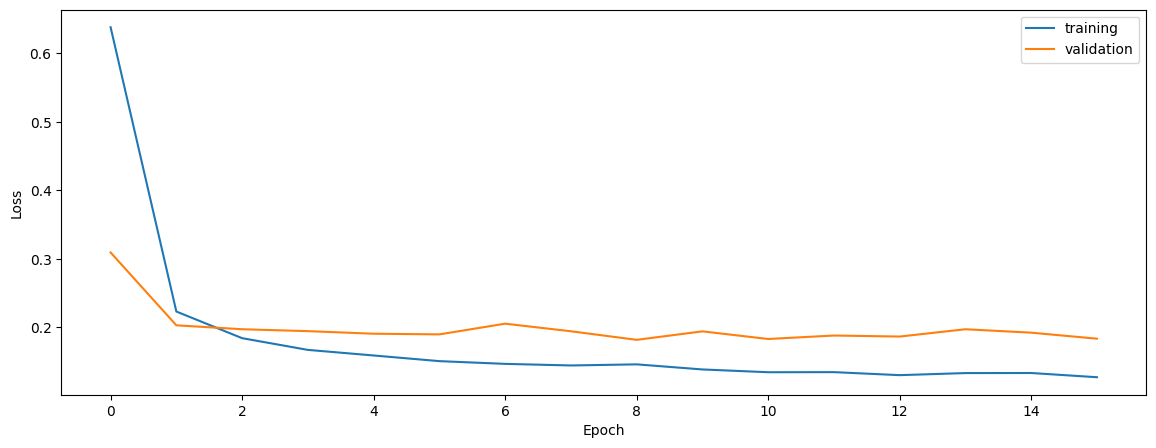

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.9473259074657965


0.932752032146656


0.9326954888898824


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.9558091620779366


0.9358435340196767


0.9405583074857645


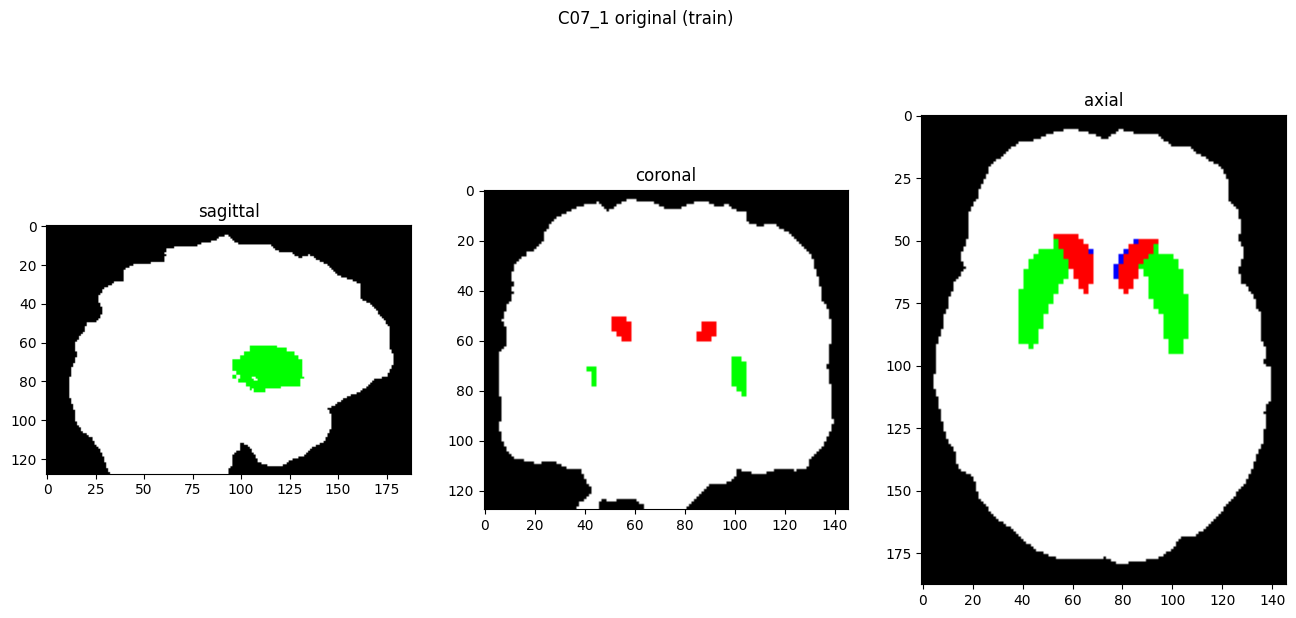

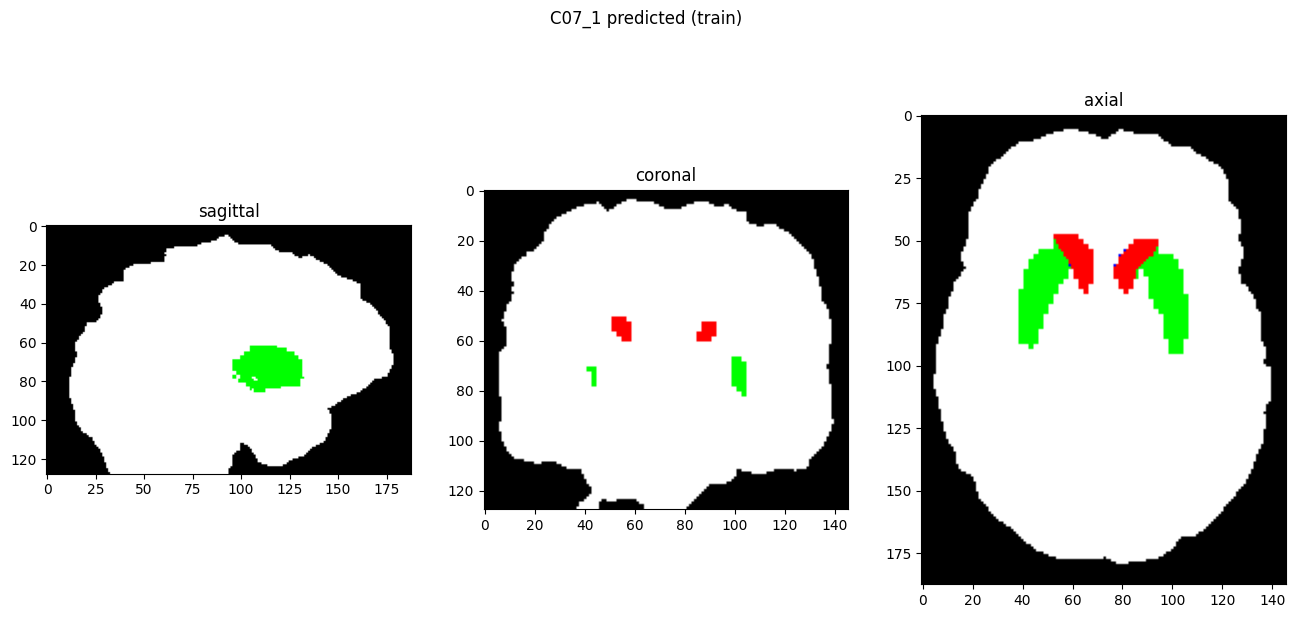

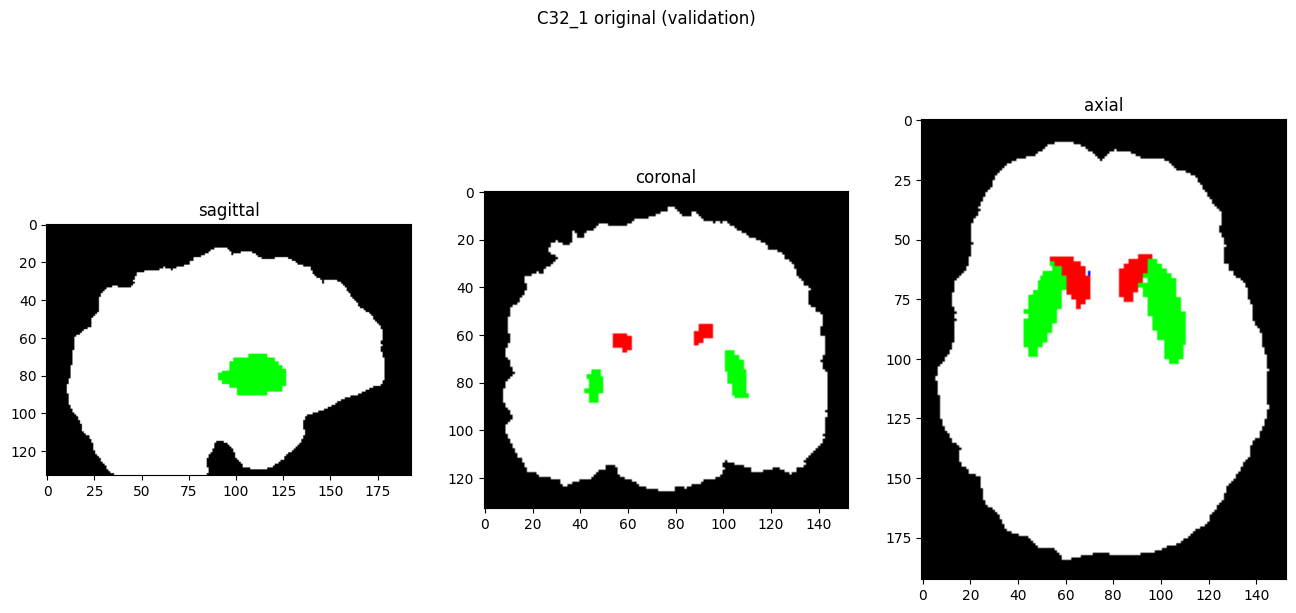

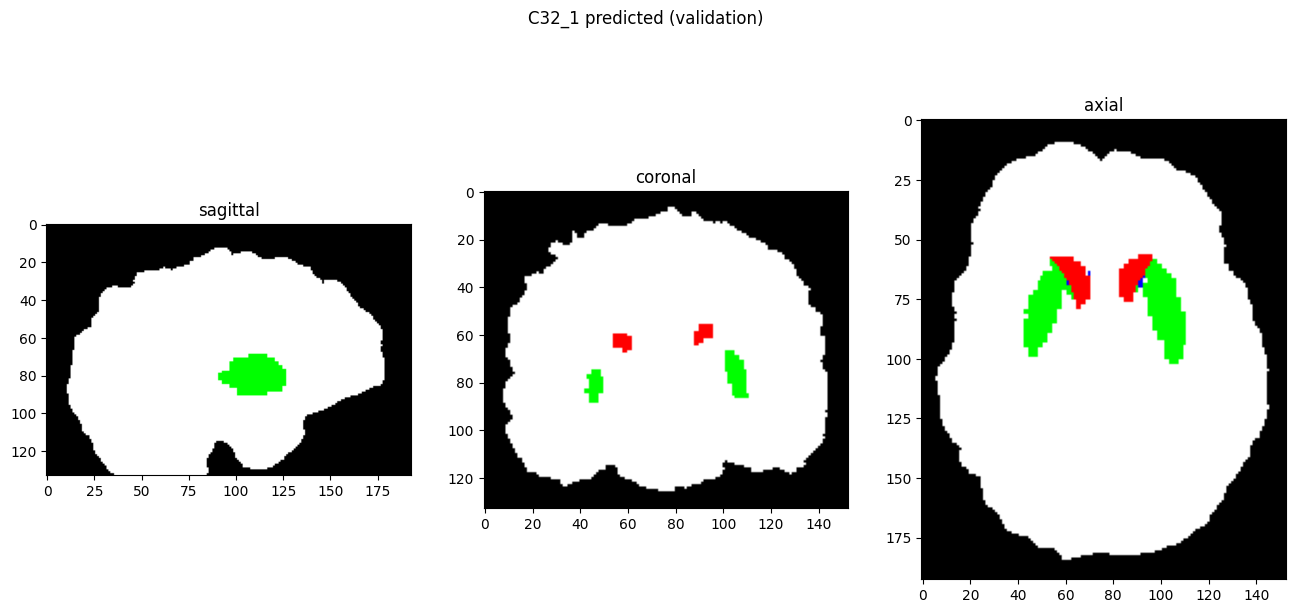

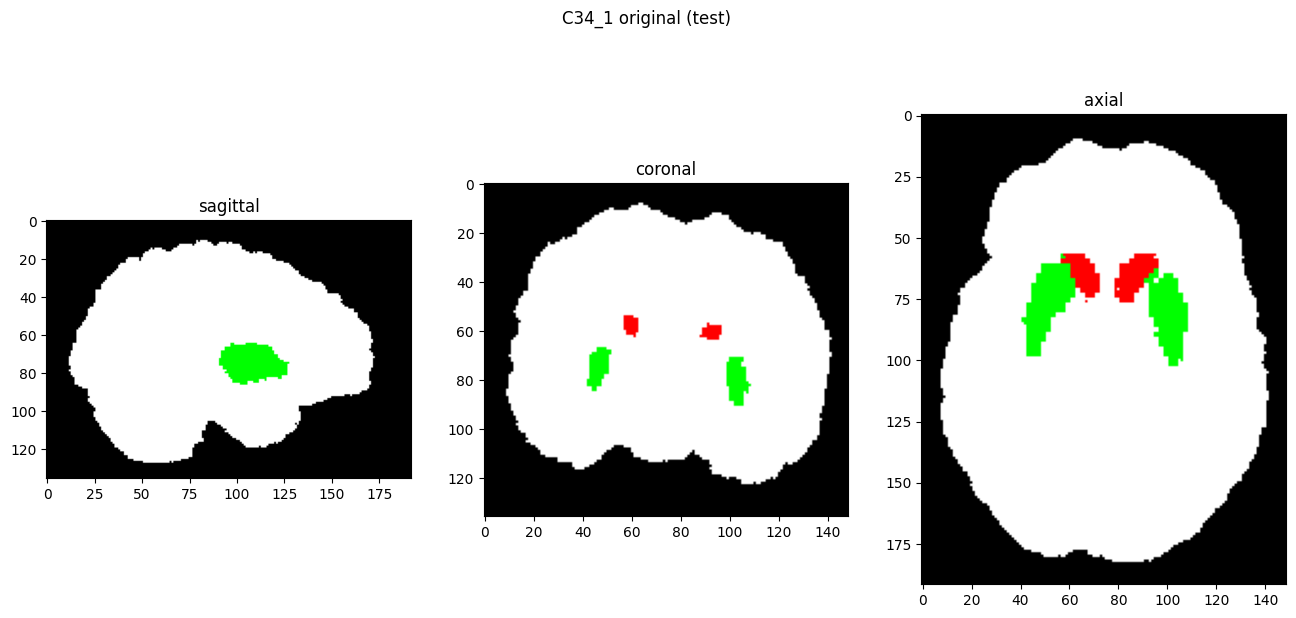

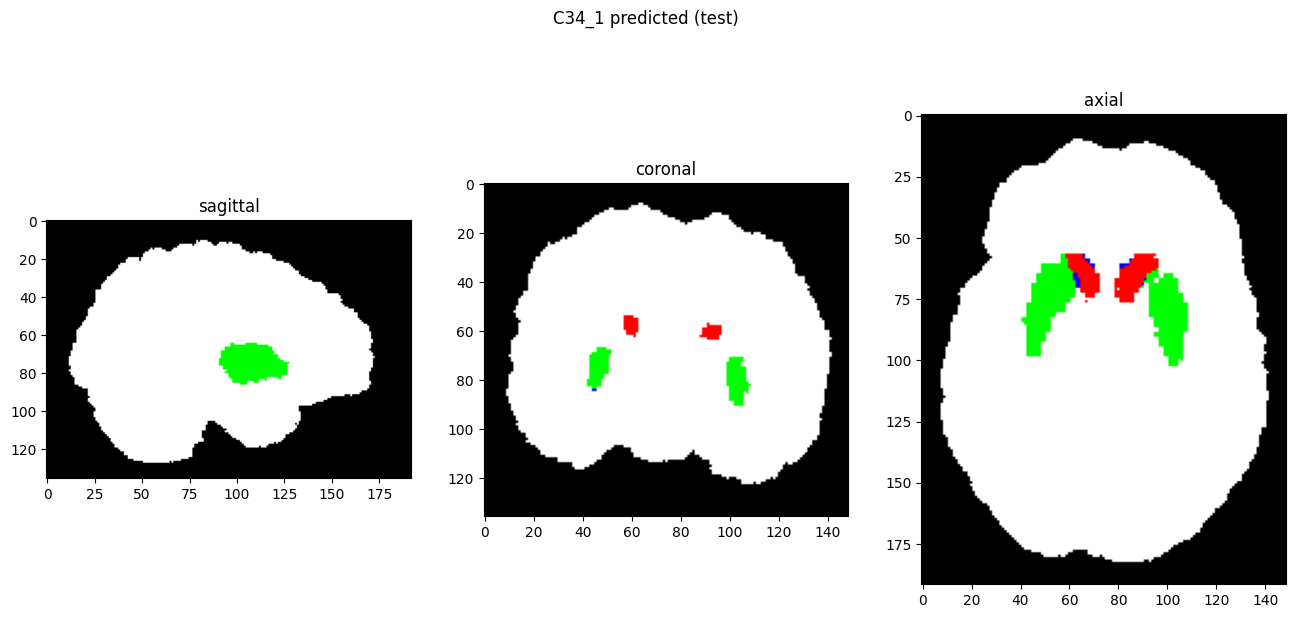

In [9]:
showResults(model, gen, threshold=0)